# 二部网络鲁棒性分析

- 评估网络鲁棒性：在不同节点移除策略下，二部生态网络在功能上能坚持到什么程度。
- 找出关键物种/节点：哪些节点最影响网络连通性与稳定性。
- 对比策略与网络：比较不同网络（Prunus、Pollinator）和不同移除策略的表现，给出结论性解释。

In [13]:
# 环境初始化（跨设备、无需绝对路径）
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import json
import seaborn as sns
from collections import defaultdict
import warnings
import os

# 抑制所有警告和不必要的调试输出
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# 抑制 NumPy/SciPy 的调试信息
import logging
logging.getLogger().setLevel(logging.ERROR)

# 自动定位仓库根目录：向上寻找同时包含 src/ 与 tests/ 的目录
def find_repo_root(start: Path = Path.cwd()) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').exists() and (p / 'tests').exists():
            return p
    return start  # 兜底：当前目录

REPO_ROOT = find_repo_root()
BASE_RESULTS = REPO_ROOT / 'tests' / 'results'

# 强制英文字体（与原配置一致）
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

print(f"Repo root: {REPO_ROOT}")
print("环境初始化完成（使用相对路径）")

Repo root: /Users/limengxiao/Desktop/info/M2/AALA/projet_trois/AAGA_Robustesse_Reseaux_Bipartis
环境初始化完成（使用相对路径）


In [14]:
# 数据加载函数（支持相对仓库根目录的路径）
def load_bipartite_from_json(file_path, directed=True):
    # 将相对路径解析到仓库根目录 REPO_ROOT
    fp = Path(file_path)
    if not fp.is_absolute():
        fp = REPO_ROOT / fp
    with open(fp, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    # 添加节点
    for node in data["nodes"]:
        # 使用group字段，并映射到type
        group = node.get("group", "unknown")
        if group in ["Herbivore", "Pollinator"]:
            node_type = "active"
        elif group == "Plant":
            node_type = "passive"
        else:
            node_type = "unknown"
        
        G.add_node(node["nodeid"], name=node["name"], type=node_type)
    
    # 创建ID映射（从整数ID到字符串nodeid）
    id_mapping = {}
    for i, node in enumerate(data["nodes"]):
        id_mapping[i] = node["nodeid"]  # 使用索引作为整数ID
    
    # 添加边
    for link in data["links"]:
        source_id = id_mapping[link["source"]]
        target_id = id_mapping[link["target"]]
        G.add_edge(source_id, target_id)
    
    return G

print("数据加载函数定义完成")

数据加载函数定义完成


In [15]:
# 论文标准可视化函数
def visualize_network_with_importance(G, active_nodes, passive_nodes, 
                                    active_scores, passive_scores, 
                                    title, figsize=(24, 16), show_labels=True):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
 
    MORANDI_COLORS = {
        "high": "#8B7D6B",     
        "medium": "#A8B5A0",   
        "low": "#C4B5A0",      
        "edge": "#6B7B8C",     
        "label_bg": "#E8E0D0",  
        "label_border": "#8B7D6B", 
        "text": "#4A4A4A"       
    }
    
    # 计算节点大小（基于重要性）
    def calculate_node_sizes(nodes, scores, base_size=300, max_size=800):
        if not scores:
            return [base_size] * len(nodes)
        
        max_score = max(scores.values()) if scores.values() else 1
        min_score = min(scores.values()) if scores.values() else 0
        
        if max_score == min_score:
            return [base_size] * len(nodes)
        
        sizes = []
        for node in nodes:
            score = scores.get(node, 0)
            normalized_score = (score - min_score) / (max_score - min_score)
            size = base_size + normalized_score * (max_size - base_size)
            sizes.append(size)
        return sizes
    
    # 计算边宽度（基于连接强度）
    def calculate_edge_widths(G, base_width=0.5, max_width=2.0):
        if G.number_of_edges() == 0:
            return []
        
        edge_weights = []
        for edge in G.edges():
            source, target = edge
            source_importance = active_scores.get(source, 0) + passive_scores.get(source, 0)
            target_importance = active_scores.get(target, 0) + passive_scores.get(target, 0)
            edge_weight = source_importance + target_importance
            edge_weights.append(edge_weight)
        
        if not edge_weights:
            return [base_width] * G.number_of_edges()
        
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        
        if max_weight == min_weight:
            return [base_width] * len(edge_weights)
        
        widths = []
        for weight in edge_weights:
            normalized_weight = (weight - min_weight) / (max_weight - min_weight)
            width = base_width + normalized_weight * (max_width - base_width)
            widths.append(width)
        return widths
    
    # 按重要性排序节点（重要节点在上方）
    active_sorted = sorted(active_nodes, key=lambda x: active_scores.get(x, 0), reverse=True)
    passive_sorted = sorted(passive_nodes, key=lambda x: passive_scores.get(x, 0), reverse=True)
    
    # 计算节点大小（重要节点在上方）
    active_sizes = calculate_node_sizes(active_sorted, active_scores)
    passive_sizes = calculate_node_sizes(passive_sorted, passive_scores)
    
    # 创建布局（重要节点在上方）
    pos = {}
    
    # 主动节点在左侧（重要节点在上方）- 修复排序问题
    for i, node in enumerate(active_sorted):
        pos[node] = (0, len(active_sorted) - i - 1)  # 反转Y坐标，重要节点在上方
    
    # 被动节点在右侧（间隔到图齐平，按重要性排序）
    max_height = max(len(active_sorted), len(passive_sorted))
    if len(passive_sorted) > 1:
        # 被动物种均匀分布到整个图的高度，按重要性排序
        for i, node in enumerate(passive_sorted):
            y_pos = (len(passive_sorted) - i - 1) * (max_height - 1) / (len(passive_sorted) - 1)  # 反转Y坐标，重要节点在上方
            pos[node] = (6, y_pos)
    else:
        if len(passive_sorted) == 1:
            pos[passive_sorted[0]] = (6, max_height / 2)
    
    # 计算边宽度
    edge_widths = calculate_edge_widths(G)
    
    # 绘制边（降低透明度，避免黑色遮挡）
    if edge_widths:
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=MORANDI_COLORS["edge"], 
                              width=edge_widths, arrows=True, arrowsize=25, 
                              arrowstyle="->", ax=ax)
    else:
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=MORANDI_COLORS["edge"], 
                              width=0.8, arrows=True, arrowsize=25, 
                              arrowstyle="->", ax=ax)
    
    # 绘制主动节点（重要节点在上方）
    active_colors = []
    for i, node in enumerate(active_sorted):
        # 根据排序位置分配颜色（重要节点在上方）
        if i < len(active_sorted) * 0.2:  # 前20%为高重要性
            active_colors.append(MORANDI_COLORS["high"])
        elif i < len(active_sorted) * 0.5:  # 20%-50%为中等重要性
            active_colors.append(MORANDI_COLORS["medium"])
        else:
            active_colors.append(MORANDI_COLORS["low"])
    
    nx.draw_networkx_nodes(G, pos, nodelist=active_sorted, 
                          node_color=active_colors, node_size=active_sizes, 
                          alpha=0.8, edgecolors="#4A4A4A", linewidths=1, ax=ax)
    
    # 绘制被动节点（重要节点在上方）
    passive_colors = []
    for i, node in enumerate(passive_sorted):
        # 根据排序位置分配颜色（重要节点在上方）
        if i < len(passive_sorted) * 0.2:  # 前20%为高重要性
            passive_colors.append(MORANDI_COLORS["high"])
        elif i < len(passive_sorted) * 0.5:  # 20%-50%为中等重要性
            passive_colors.append(MORANDI_COLORS["medium"])
        else:
            passive_colors.append(MORANDI_COLORS["low"])
    
    nx.draw_networkx_nodes(G, pos, nodelist=passive_sorted, 
                          node_color=passive_colors, node_size=passive_sizes, 
                          alpha=0.8, edgecolors="#4A4A4A", linewidths=1, ax=ax)
    
    # 只为重要节点添加标签（完全避免遮挡）- 只在show_labels=True时显示
    if show_labels:
        def add_important_labels(G, pos, nodes, scores, top_n=5, side_offset=1.0, label_length=10, show_labels_flag=True):
            if not scores or not show_labels_flag:
                return
            
            sorted_nodes = sorted(nodes, key=lambda x: scores.get(x, 0), reverse=True)[:top_n]
            
            for node in sorted_nodes:
                node_name = G.nodes[node]["name"][:label_length]
                x, y = pos[node]
                # 标签写在远离节点的位置，完全避免遮挡
                ax.text(x + side_offset, y, node_name, 
                       fontsize=12, color=MORANDI_COLORS["text"], 
                       fontweight="bold", ha="left" if side_offset > 0 else "right", va="center",
                       bbox=dict(boxstyle="round,pad=0.3", facecolor=MORANDI_COLORS["label_bg"], 
                                alpha=0.9, edgecolor=MORANDI_COLORS["label_border"], linewidth=1))
        
        # 添加重要节点标签（远离节点，避免遮挡）
        add_important_labels(G, pos, active_sorted, active_scores, top_n=5, side_offset=1.0)
        add_important_labels(G, pos, passive_sorted, passive_scores, top_n=len(passive_sorted), side_offset=-1.0)
    
    # 标题放在正上方（字体放大）
    ax.set_title(f"{title}\nNode size = Importance, Edge width = Connection strength", 
                fontsize=22, fontweight="bold", pad=30, color=MORANDI_COLORS["text"])
    
    # 侧边标签（始终显示，不管show_labels参数）
    ax.text(-1.2, max_height / 2, "Active Species\n(Decreasing Importance)", 
            ha="right", va="center", fontsize=18, fontweight="bold", 
            rotation=90, bbox=dict(boxstyle="round,pad=0.6", facecolor=MORANDI_COLORS["label_bg"], 
                                   alpha=0.9, edgecolor=MORANDI_COLORS["label_border"], linewidth=1),
            color=MORANDI_COLORS["text"])
    ax.text(7.2, max_height / 2, "Passive Species\n(Decreasing Vulnerability)", 
            ha="left", va="center", fontsize=18, fontweight="bold", 
            rotation=90, bbox=dict(boxstyle="round,pad=0.6", facecolor=MORANDI_COLORS["label_bg"], 
                                   alpha=0.9, edgecolor=MORANDI_COLORS["label_border"], linewidth=1),
            color=MORANDI_COLORS["text"])
    
    ax.set_xlim(-2.5, 8.5)
    ax.set_ylim(-0.5, max_height + 0.5)
    ax.axis("off")
    
    plt.tight_layout()
    plt.show()

print("可视化函数定义完成")

可视化函数定义完成


=== Prunus Network Analysis ===
Prunus网络: 64个主动节点, 5个被动节点


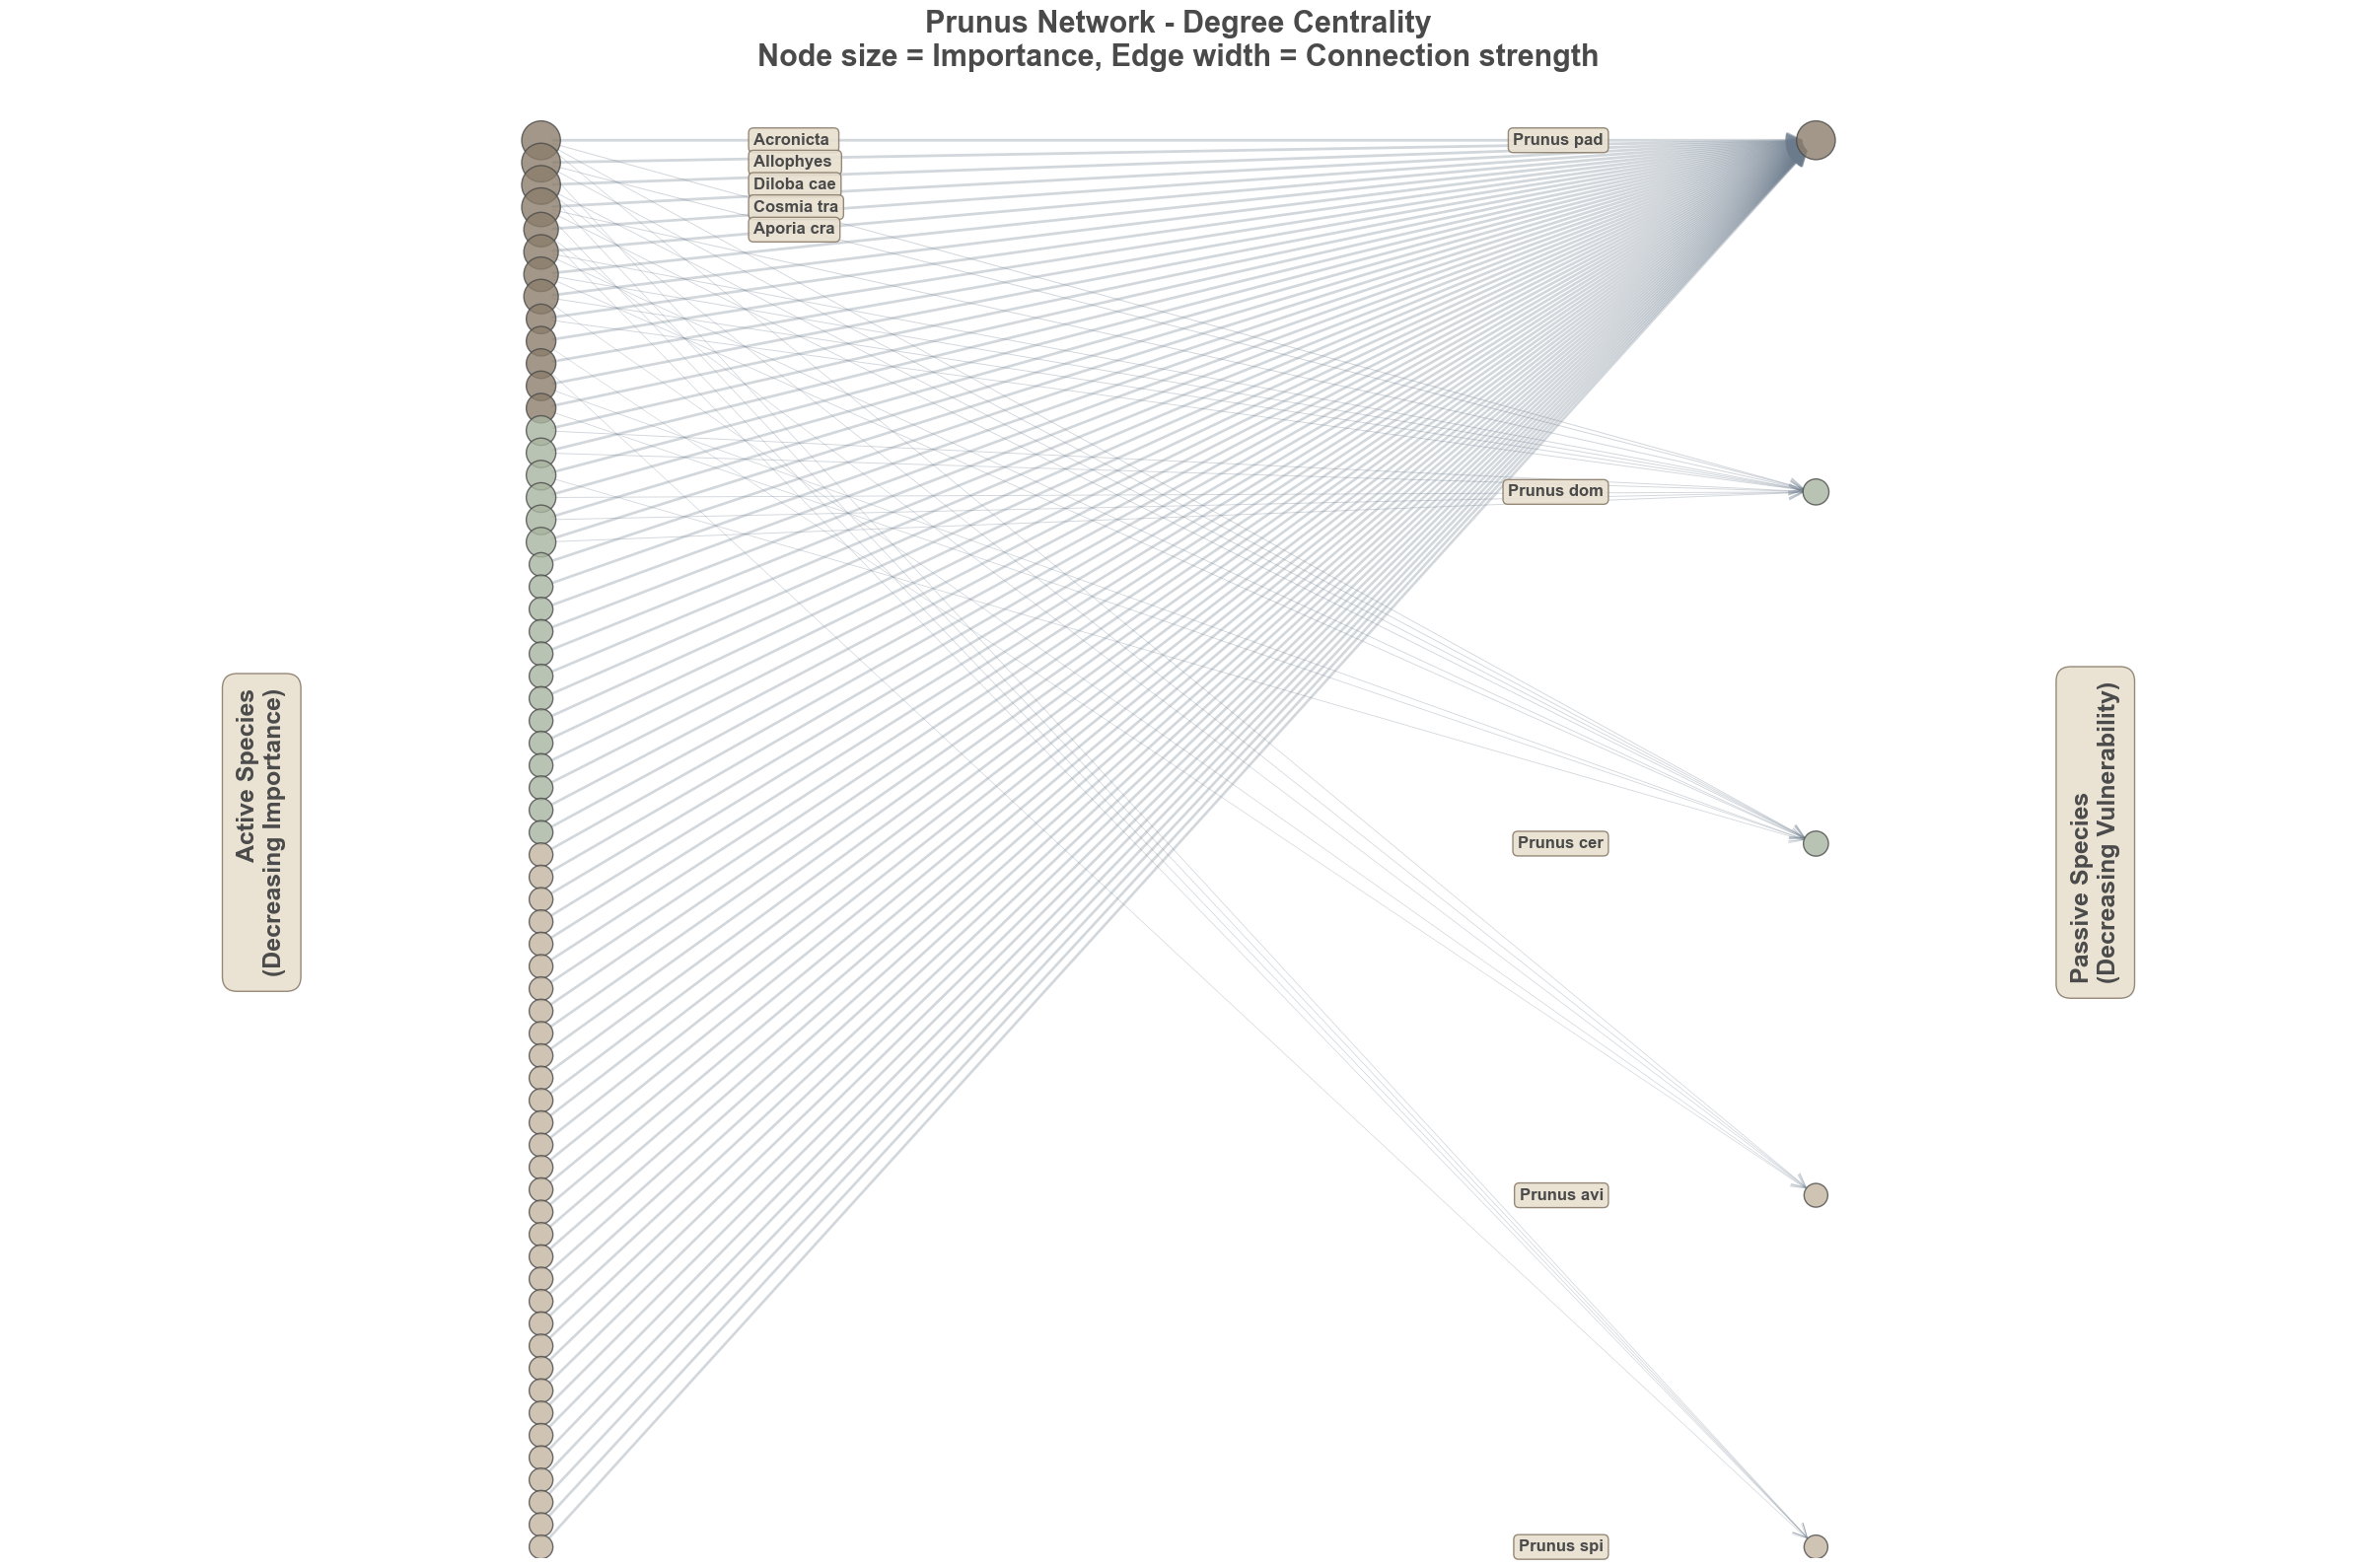

Prunus network analysis completed

=== Pollinator Network Analysis ===
Pollinator网络: 677个主动节点, 91个被动节点


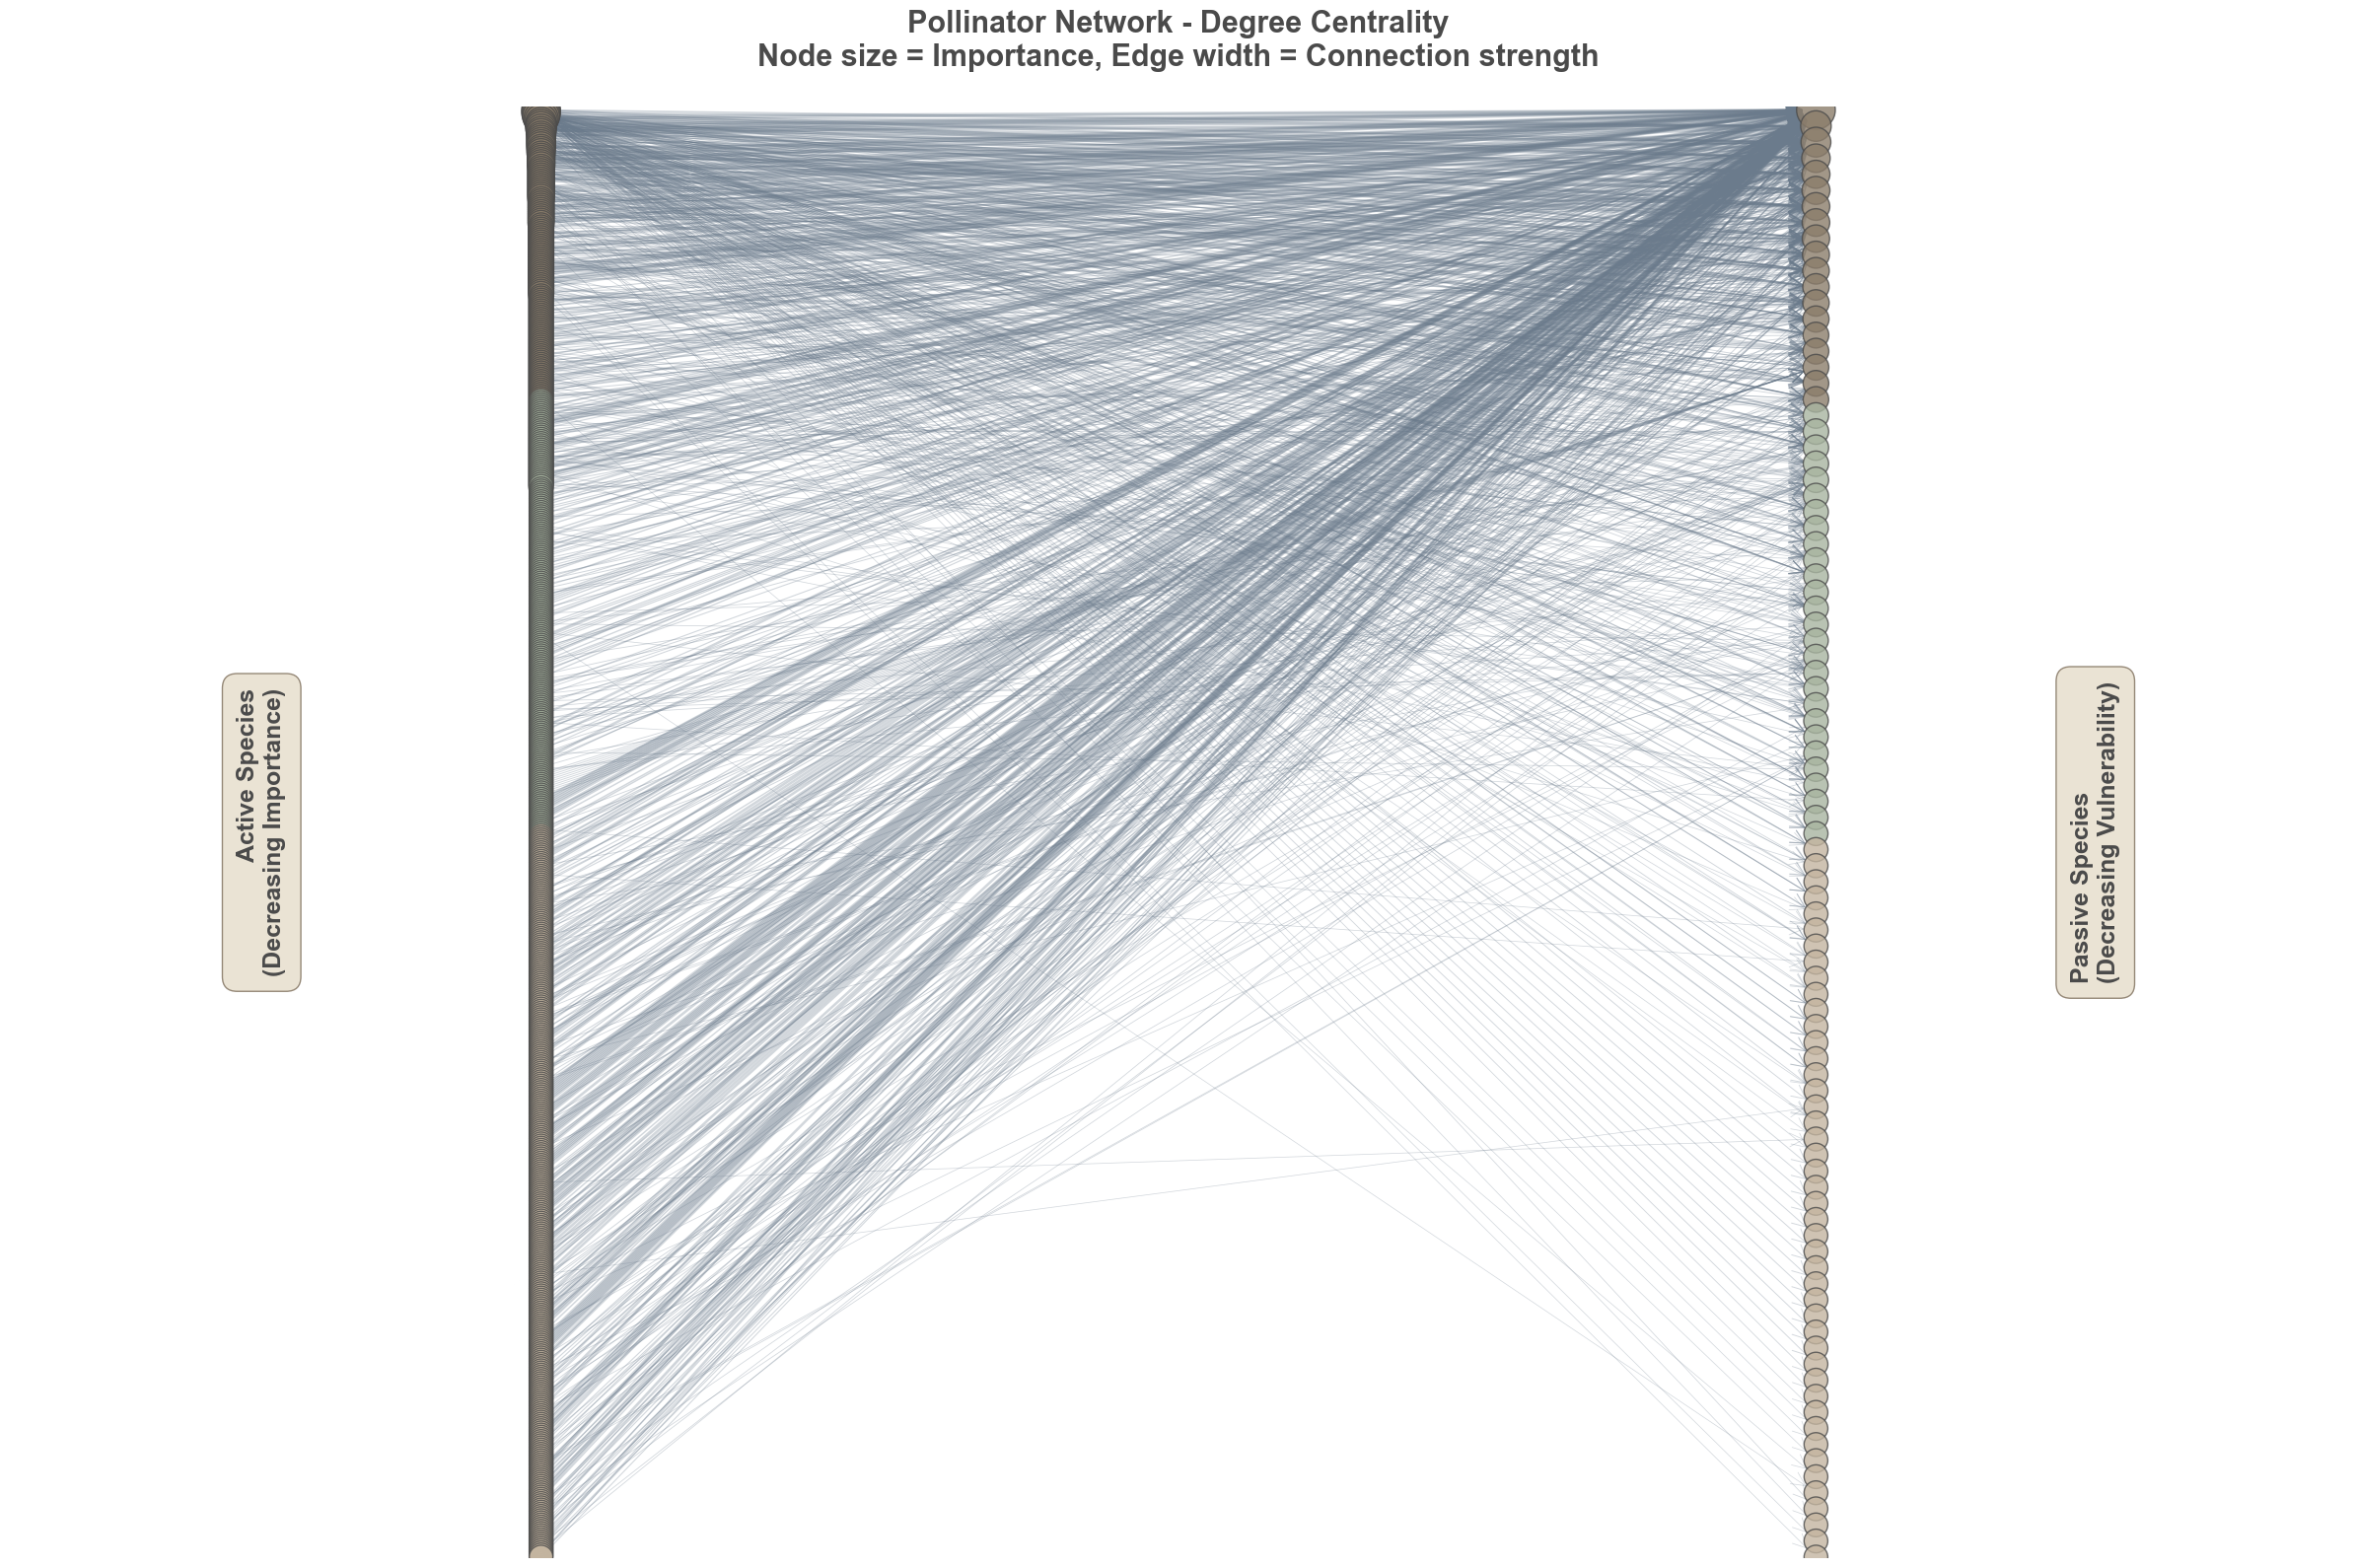

Pollinator network analysis completed


In [16]:
# 数据加载和可视化演示
print("=== Prunus Network Analysis ===")

# 加载Prunus网络
G_prunus = load_bipartite_from_json("tests/network_prunus.json", directed=True)

# 分离主动和被动节点
active_prunus = [node for node in G_prunus.nodes() if G_prunus.nodes[node]["type"] == "active"]
passive_prunus = [node for node in G_prunus.nodes() if G_prunus.nodes[node]["type"] == "passive"]

print(f"Prunus网络: {len(active_prunus)}个主动节点, {len(passive_prunus)}个被动节点")

# 计算Degree中心性
degree_prunus = dict(G_prunus.out_degree(active_prunus))
passive_in_degree_prunus = dict(G_prunus.in_degree(passive_prunus))

# 可视化网络（显示标签）
visualize_network_with_importance(G_prunus, active_prunus, passive_prunus,
                                degree_prunus, passive_in_degree_prunus,
                                "Prunus Network - Degree Centrality", show_labels=True)

print("Prunus network analysis completed")

# 加载Pollinator网络
print("\n=== Pollinator Network Analysis ===")
G_pollinator = load_bipartite_from_json("tests/network_pollinator.json", directed=True)

# 分离主动和被动节点
active_pollinator = [node for node in G_pollinator.nodes() if G_pollinator.nodes[node]["type"] == "active"]
passive_pollinator = [node for node in G_pollinator.nodes() if G_pollinator.nodes[node]["type"] == "passive"]

print(f"Pollinator网络: {len(active_pollinator)}个主动节点, {len(passive_pollinator)}个被动节点")

# 计算Degree中心性
degree_pollinator = dict(G_pollinator.out_degree(active_pollinator))
passive_in_degree_pollinator = dict(G_pollinator.in_degree(passive_pollinator))

# 可视化网络（不显示标签）
visualize_network_with_importance(G_pollinator, active_pollinator, passive_pollinator,
                                degree_pollinator, passive_in_degree_pollinator,
                                "Pollinator Network - Degree Centrality", show_labels=False)

print("Pollinator network analysis completed")


Step 1: Data Preprocessing

Processing Prunus network...

1.1 Network construction:
  - Bipartite network structure:
    * active: 64 nodes
    * passive: 5 nodes
  - Total edges (interactions): 95

  - Adjacency matrix A[i,j]:
    * Matrix shape: (69, 69)
    * A[i,j] = 1 if species i and j interact, 0 otherwise
    * Number of interactions: 95


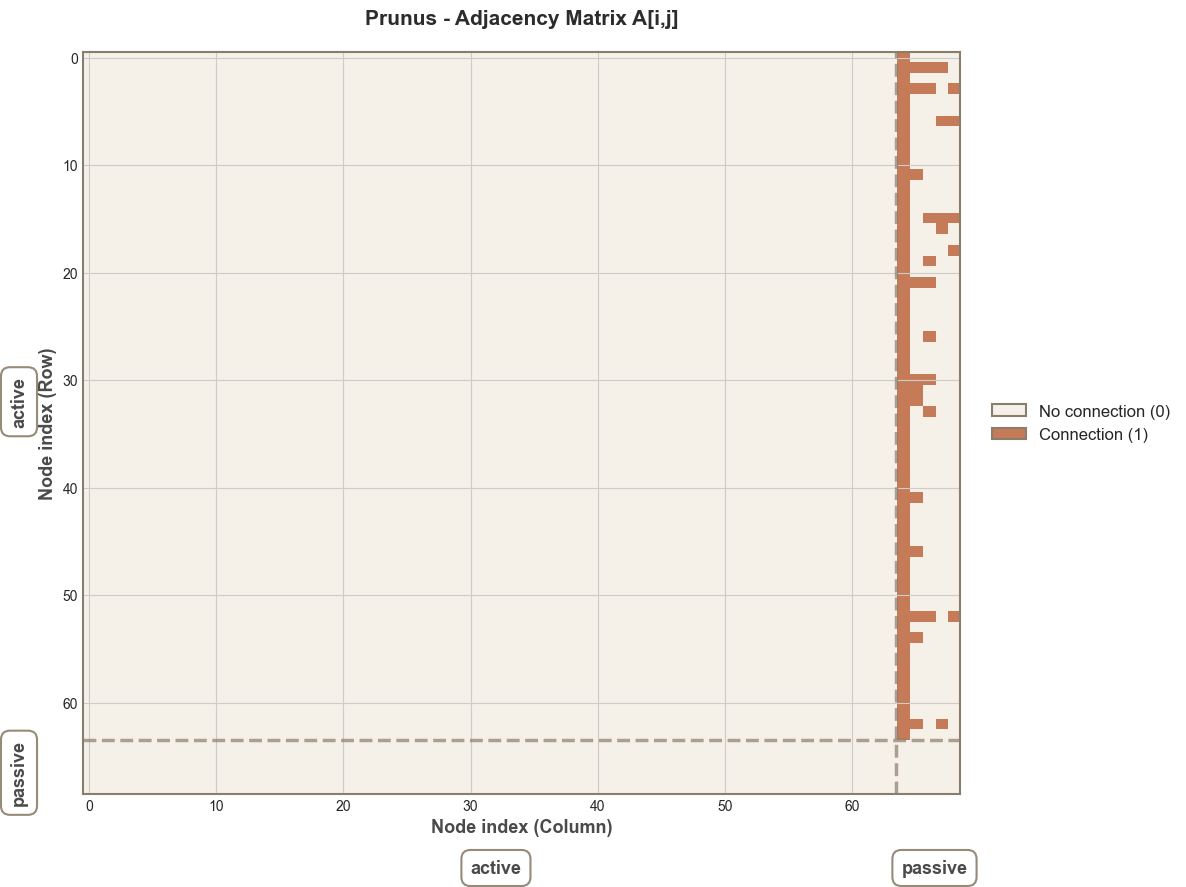


1.2 Data standardization:
  - Connection strength (degree):
    * Average: 2.75
    * Range: [1, 64]
    * Std: 7.65


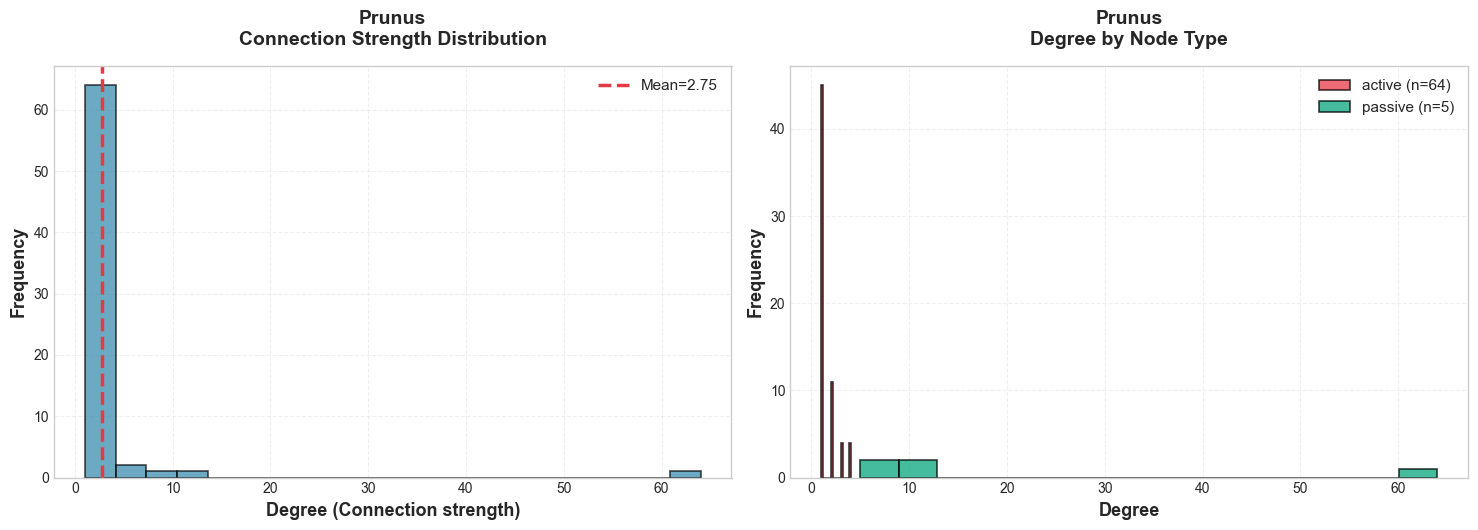


  - Network density:
    * Density: 0.2969 (29.69%)
    * Actual connections: 95
    * Possible connections: 320

  - Degree distribution statistics:
    * Mean ± Std: 2.75 ± 7.65
    * Median: 1.00
    * Min: 1, Max: 64

Processing Pollinator network...

1.1 Network construction:
  - Bipartite network structure:
    * active: 677 nodes
    * passive: 91 nodes
  - Total edges (interactions): 1193

  - Adjacency matrix A[i,j]:
    * Matrix shape: (768, 768)
    * A[i,j] = 1 if species i and j interact, 0 otherwise
    * Number of interactions: 1193


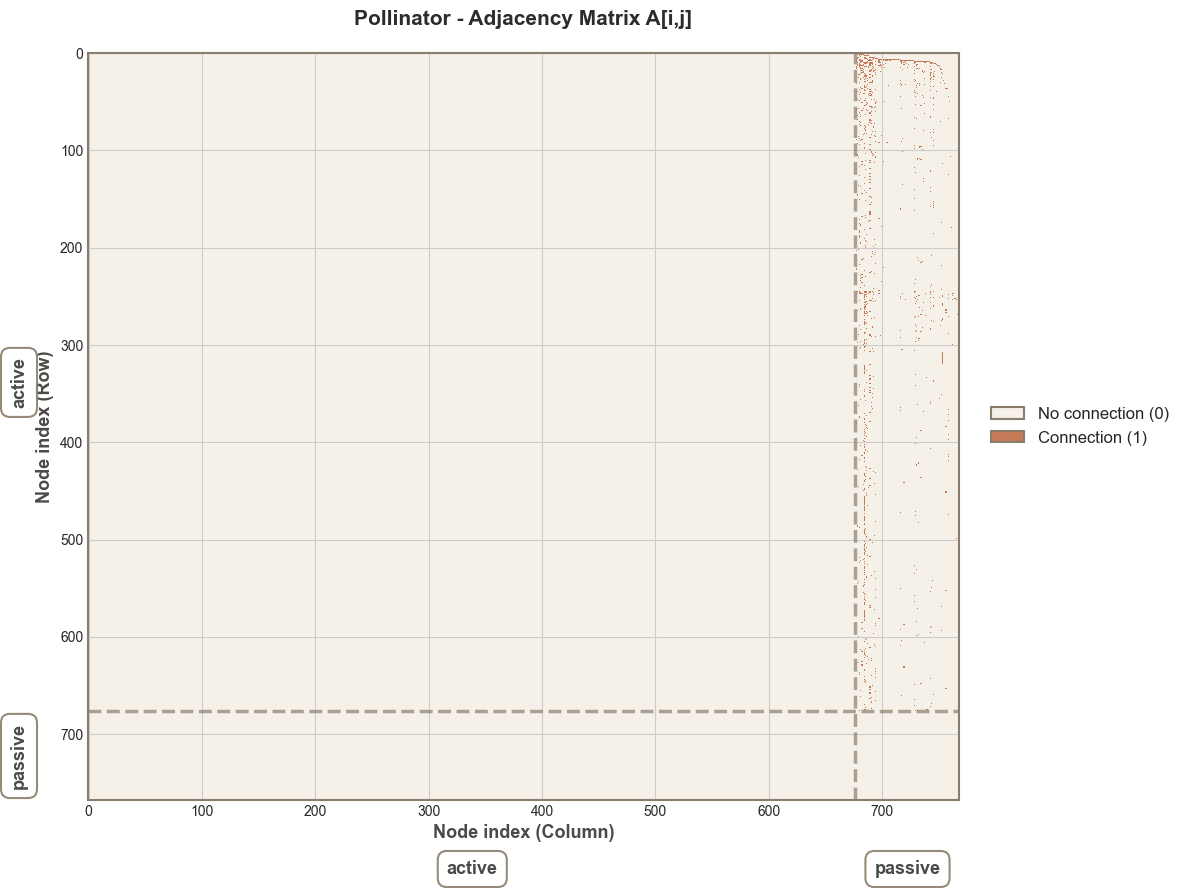


1.2 Data standardization:
  - Connection strength (degree):
    * Average: 3.11
    * Range: [1, 188]
    * Std: 9.20


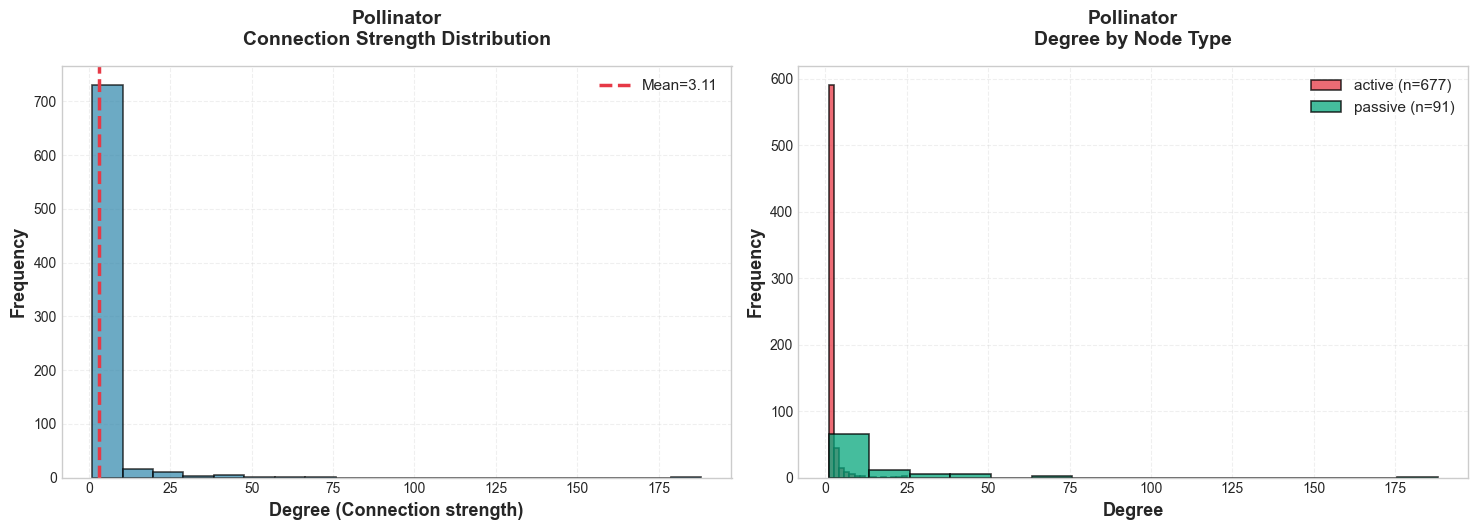


  - Network density:
    * Density: 0.0194 (1.94%)
    * Actual connections: 1193
    * Possible connections: 61607

  - Degree distribution statistics:
    * Mean ± Std: 3.11 ± 9.20
    * Median: 1.00
    * Min: 1, Max: 188

Data preprocessing completed!


In [17]:
# ===== 1. Data Preprocessing =====

print("\n" + "="*80)
print("Step 1: Data Preprocessing")
print("="*80)

def preprocess_bipartite_network(G, network_name):
    """Data preprocessing for bipartite network"""
    
    print(f"\nProcessing {network_name} network...")
    
    # 1. Network construction
    print("\n1.1 Network construction:")
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    # Separate nodes by type
    nodes_by_type = {}
    for node in G.nodes():
        node_type = G.nodes[node].get('type', 'unknown')
        if node_type not in nodes_by_type:
            nodes_by_type[node_type] = []
        nodes_by_type[node_type].append(node)
    
    print(f"  - Bipartite network structure:")
    node_types = list(nodes_by_type.keys())
    for node_type in node_types:
        nodes = nodes_by_type[node_type]
        print(f"    * {node_type}: {len(nodes)} nodes")
    print(f"  - Total edges (interactions): {n_edges}")
    
    # Create adjacency matrix
    print(f"\n  - Adjacency matrix A[i,j]:")
    
    # Order nodes by type
    if len(node_types) == 2:
        type1_nodes = nodes_by_type[node_types[0]]
        type2_nodes = nodes_by_type[node_types[1]]
        ordered_nodes = type1_nodes + type2_nodes
    else:
        ordered_nodes = list(G.nodes())
    
    adj_matrix = nx.to_numpy_array(G, nodelist=ordered_nodes)
    print(f"    * Matrix shape: {adj_matrix.shape}")
    print(f"    * A[i,j] = 1 if species i and j interact, 0 otherwise")
    print(f"    * Number of interactions: {int(np.sum(adj_matrix))}")
    
    # Visualize adjacency matrix with beautiful low-saturation colors
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch
    
    # Low-saturation colors: light beige for 0, soft terracotta for 1
    colors = ['#F5F1E8', '#C57B57']  # No connection (light beige), Connection (soft terracotta)
    cmap = ListedColormap(colors)
    
    fig, ax = plt.subplots(1, 1, figsize=(13, 10))
    im = ax.imshow(adj_matrix, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=1)
    
    # Add grid lines and labels with better styling
    if len(node_types) == 2:
        n_type1 = len(type1_nodes)
        # Subtle dividing lines
        ax.axhline(y=n_type1-0.5, color='#8B7D6B', linewidth=2.5, linestyle='--', alpha=0.7)
        ax.axvline(x=n_type1-0.5, color='#8B7D6B', linewidth=2.5, linestyle='--', alpha=0.7)
        
        # Add type labels with background boxes
        bbox_props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#8B7D6B', alpha=0.9, linewidth=1.5)
        ax.text(-adj_matrix.shape[1] * 0.08, n_type1/2, node_types[0], rotation=90, va='center', ha='center',
                fontsize=13, fontweight='bold', color='#4A4A4A', bbox=bbox_props)
        ax.text(-adj_matrix.shape[1] * 0.08, n_type1 + len(type2_nodes)/2, node_types[1], rotation=90, va='center', ha='center',
                fontsize=13, fontweight='bold', color='#4A4A4A', bbox=bbox_props)
        ax.text(n_type1/2, adj_matrix.shape[0] * 1.08, node_types[0], ha='center', va='top',
                fontsize=13, fontweight='bold', color='#4A4A4A', bbox=bbox_props)
        ax.text(n_type1 + len(type2_nodes)/2, adj_matrix.shape[0] * 1.08, node_types[1], ha='center', va='top',
                fontsize=13, fontweight='bold', color='#4A4A4A', bbox=bbox_props)
    
    # Title and labels with better formatting
    title_text = f'{network_name} - Adjacency Matrix A[i,j]'
    ax.set_xlabel('Node index (Column)', fontsize=13, fontweight='bold', color='#4A4A4A')
    ax.set_ylabel('Node index (Row)', fontsize=13, fontweight='bold', color='#4A4A4A')
    ax.set_title(title_text, fontsize=15, fontweight='bold', color='#2C2C2C', pad=20)
    
    # Custom legend instead of colorbar
    legend_elements = [
        Patch(facecolor='#F5F1E8', edgecolor='#8B7D6B', label='No connection (0)', linewidth=1.5),
        Patch(facecolor='#C57B57', edgecolor='#8B7D6B', label='Connection (1)', linewidth=1.5)
    ]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12, 
             framealpha=0.95, edgecolor='#8B7D6B', fancybox=True, shadow=True)
    
    # Beautify spines
    for spine in ax.spines.values():
        spine.set_edgecolor('#8B7D6B')
        spine.set_linewidth(1.5)
    
    plt.tight_layout(rect=[0.05, 0.08, 0.98, 0.98])
    plt.show()
    
    # 2. Data standardization
    print("\n1.2 Data standardization:")
    
    # Connection strength
    degree_dict = dict(G.degree())
    degree_values = list(degree_dict.values())
    avg_degree = np.mean(degree_values)
    max_degree = max(degree_values)
    min_degree = min(degree_values)
    
    print(f"  - Connection strength (degree):")
    print(f"    * Average: {avg_degree:.2f}")
    print(f"    * Range: [{min_degree}, {max_degree}]")
    print(f"    * Std: {np.std(degree_values):.2f}")
    
    # Visualize with better colors and layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.hist(degree_values, bins=20, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.2)
    ax1.axvline(avg_degree, color='#E63946', linestyle='--', linewidth=2.5, label=f'Mean={avg_degree:.2f}')
    ax1.set_xlabel('Degree (Connection strength)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    title1 = network_name + '\n' + 'Connection Strength Distribution'
    ax1.set_title(title1, fontsize=14, fontweight='bold', pad=15)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    colors_map = {'active': '#E63946', 'passive': '#06A77D', 'Herbivore': '#E63946', 'Plant': '#06A77D', 'Pollinator': '#F77F00'}
    for node_type, nodes in nodes_by_type.items():
        type_degrees = [degree_dict[node] for node in nodes]
        color = colors_map.get(node_type, '#457B9D')
        ax2.hist(type_degrees, bins=15, alpha=0.75, label=f'{node_type} (n={len(nodes)})', color=color, edgecolor='black', linewidth=1.2)
    ax2.set_xlabel('Degree', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    title2 = network_name + '\n' + 'Degree by Node Type'
    ax2.set_title(title2, fontsize=14, fontweight='bold', pad=15)
    ax2.legend(fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout(rect=[0.05, 0.08, 0.98, 0.98])
    plt.show()
    
    # Network density
    if len(node_types) == 2:
        n1 = len(nodes_by_type[node_types[0]])
        n2 = len(nodes_by_type[node_types[1]])
        max_possible_edges = n1 * n2
        density = n_edges / max_possible_edges if max_possible_edges > 0 else 0
    else:
        max_possible_edges = n_nodes * (n_nodes - 1) / 2
        density = n_edges / max_possible_edges if max_possible_edges > 0 else 0
    
    print("\n  - Network density:")
    print(f"    * Density: {density:.4f} ({density*100:.2f}%)")
    print(f"    * Actual connections: {n_edges}")
    print(f"    * Possible connections: {int(max_possible_edges)}")
    
    print("\n  - Degree distribution statistics:")
    print(f"    * Mean ± Std: {np.mean(degree_values):.2f} ± {np.std(degree_values):.2f}")
    print(f"    * Median: {np.median(degree_values):.2f}")
    print(f"    * Min: {min_degree}, Max: {max_degree}")
    
    return {'n_nodes': n_nodes, 'n_edges': n_edges, 'density': density, 'degree_dict': degree_dict, 'nodes_by_type': nodes_by_type, 'avg_degree': avg_degree, 'adj_matrix': adj_matrix}

# Apply preprocessing
prunus_props = preprocess_bipartite_network(G_prunus, "Prunus")
pollinator_props = preprocess_bipartite_network(G_pollinator, "Pollinator")

print("\n" + "="*80)
print("Data preprocessing completed!")
print("="*80)




Step 2: Adaptive Robustness Simulation

Simulating Prunus network...
  - Running DEG... (0.03s)
  - Running HITS... (0.06s)
  - Running HITS_SCRATCH... (0.01s)
  - Running MUSRANK... (0.04s)
  - Running PAGERANK... (0.09s)
  - Running RANDOM... (0.01s)

Simulating Pollinator network...
  - Running DEG... (1.75s)
  - Running HITS... (1.92s)
  - Running HITS_SCRATCH... (6.88s)
  - Running MUSRANK... (2.93s)
  - Running PAGERANK... (10.61s)
  - Running RANDOM... (1.13s)

Plotting LCC curves...



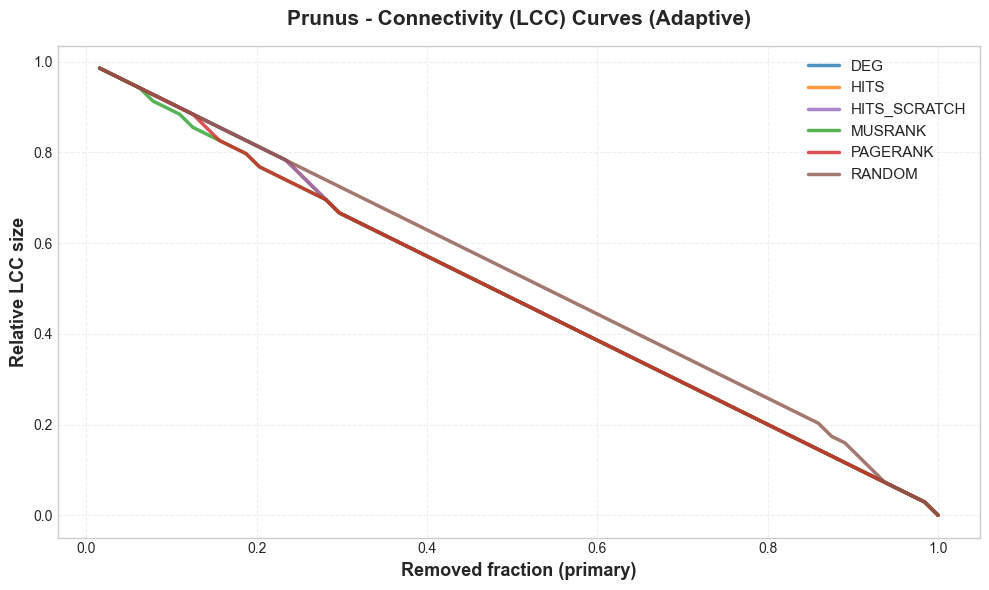

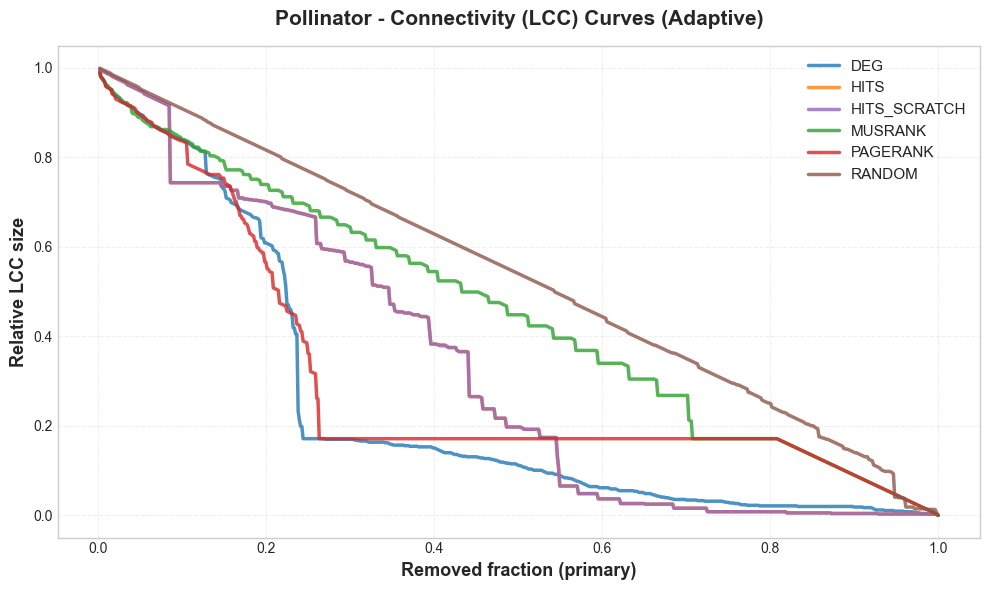


Adaptive robustness simulation completed!


In [18]:
# ===== 2. Robustness Simulation (Adaptive Protocol) =====

import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import warnings
import random 
from degree_strategy import degree_strategy as degree_scores
from hits_strategy import hits_strategy as hits_scores
from hits_strategy import hits_strategy_scratch as hits_scores_scratch
from musrank_strategy import musrank as musrank_scores
from pageRank import pageRank as pageRanks_scores
from random_score import score_random as random_scores

# 抑制警告信息和不必要的输出
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print("Step 2: Adaptive Robustness Simulation")
print("="*80)

# ===== Utility Functions =====

def ensure_bipartite_tags(G):
    """Ensure nodes have 'bipartite' attribute (required by MusRank).
    active->0, passive->1"""
    for n, d in G.nodes(data=True):
        if 'bipartite' not in d:
            t = d.get('type')
            if t == 'active':
                d['bipartite'] = 0
            elif t == 'passive':
                d['bipartite'] = 1
    return G


def lcc_ratio_l0(G_current, L0):
    """Calculate LCC ratio normalized by initial L0 (undirected)"""
    if G_current.number_of_nodes() == 0 or L0 == 0:
        return 0.0
    Gu = G_current.to_undirected()
    largest = max((len(c) for c in nx.connected_components(Gu)), default=0)
    return largest / L0


def cascade_secondary_extinctions_side(G, extinct_side: str):
    """Remove nodes from extinct_side that have degree 0"""
    removed = []
    while True:
        zeros = [n for n, d in list(G.nodes(data=True)) 
                if d.get('type') == extinct_side and G.degree(n) == 0]
        if not zeros:
            break
        G.remove_nodes_from(zeros)
        removed.extend(zeros)
    return removed


# ===== Scoring Functions (Adaptive - Recompute Every Step) =====

def score_active_nodes(G, strategy: str) -> dict:
    """
    Compute scores for active nodes using different strategies.
    
    Graph type used:
    - DEG:          Undirected (degree doesn't need direction)
    - HITS:         Directed (for consistency with HITS_SCRATCH)
    - HITS_SCRATCH: Directed (for consistency with HITS)
    - MUSRANK:      Directed (bipartite-specific)
    - PAGERANK:     Undirected (for bipartite, works better)
    - RANDOM:       N/A (random scores)
    """
    
    if strategy == 'DEG':
        # Use undirected graph for degree
        Gu = G.to_undirected()
        return {n: Gu.degree(n) for n, d in G.nodes(data=True) 
                if d.get('type') == 'active'}
    
    if strategy == 'HITS':
        # Use directed graph (for minimal difference with HITS_SCRATCH)
        try:
            hubs, _ = nx.hits(G, max_iter=500, normalized=True)
        except Exception:
            print(f"    WARNING: HITS failed on current graph (too small/degenerate)")
            return {}
        scores = {n: hubs.get(n, 0.0) for n, d in G.nodes(data=True) 
                  if d.get('type') == 'active'}
        # L1 normalization
        total = sum(scores.values())
        if total > 0:
            scores = {k: v/total for k, v in scores.items()}
        return scores
    
    if strategy == 'HITS_SCRATCH':
        # Use directed graph (for minimal difference with HITS)
        try:
            all_scores = hits_scores_scratch(G)
            scores = {n: v for n, v in all_scores.items() 
                      if G.nodes[n].get('type') == 'active'}
            # L1 normalization
            total = sum(scores.values())
            if total > 0:
                scores = {k: v/total for k, v in scores.items()}
            return scores
        except Exception:
            print(f"    WARNING: HITS_SCRATCH failed on current graph")
            return {}
    
    if strategy == 'MUSRANK':
        # Use undirected graph for MusRank
        Gu = G.to_undirected()
        result = musrank_scores(Gu)
        
        # 自动判断返回类型
        if isinstance(result, tuple) and len(result) == 2:
            # MusRank 返回 (active_scores, passive_scores)
            scores_dict = result[0]
        else:
            # MusRank 返回单个 dict
            scores_dict = result
        
        return {n: v for n, v in scores_dict.items()
                if G.nodes[n].get('type') == 'active'}

    
    if strategy == 'PAGERANK':
        # Use undirected graph for PageRank in bipartite networks
        Gu = G.to_undirected()
        try:
            adj = {u: list(Gu.neighbors(u)) for u in Gu.nodes()}
            pr = pageRanks_scores(adj,100)
        except Exception:
            print(f"    ⚠ PAGERANK算法在当前图状态下失败（图太小/退化），停止此算法的模拟")
            return {}
        return {n: pr.get(n, 0.0) for n, d in G.nodes(data=True) 
                if d.get('type') == 'active'}
    
    if strategy == 'RANDOM':
        # Random baseline (deterministic seed based on graph state)
        rng = random.Random(G.number_of_nodes() + G.number_of_edges())
        result = random_scores(G, rng)
        return {n: v for n, v in result.items() if G.nodes[n].get('type') == 'active'}
    
    raise ValueError(f'Unknown strategy: {strategy}')


# ===== Adaptive Simulation =====

def simulate_adaptive(G, target_type: str, network_name: str, strategy: str) -> pd.DataFrame:
    """
    Adaptive removal protocol:
    1. At each step, recompute scores on current graph
    2. Remove highest-scoring node
    3. Perform cascade extinctions (only on opposite side)
    4. Record LCC and metrics
    """
    # Copy graphs
    G0 = G.copy()
    Gc = G.copy()
    ensure_bipartite_tags(Gc)
    
    # Initial metrics
    target0 = [n for n, d in Gc.nodes(data=True) if d.get('type') == target_type]
    target_size0 = len(target0)
    L0 = max((len(c) for c in nx.connected_components(G0.to_undirected())), 
             default=G0.number_of_nodes())
    
    # Simulation loop
    records = []
    removed_primary = 0
    step = 0
    
    while True:
        # Check remaining targets
        remaining = [n for n, d in Gc.nodes(data=True) if d.get('type') == target_type]
        if not remaining:
            break
        
        # Adaptive scoring: recompute on current graph
        scores = score_active_nodes(Gc, strategy)
        cand = [n for n in remaining if n in scores]
        if not cand:
            break
        
        # Select highest-scoring node (with deterministic tie-breaking)
        # Sort by: 1) score (descending), 2) node ID (ascending for consistency)
        node = max(cand, key=lambda n: (scores.get(n, 0.0), str(n)))
        
        # Remove node
        if node in Gc:
            Gc.remove_node(node)
            removed_primary += 1
            
            # Cascade: only affect opposite side
            extinct_side = 'passive' if target_type == 'active' else 'active'
            removed_secondary = cascade_secondary_extinctions_side(Gc, extinct_side)
        else:
            removed_secondary = []
        
        # Record metrics
        step += 1
        frac = removed_primary / max(1, target_size0)
        lcc = lcc_ratio_l0(Gc, L0)
        
        records.append({
            'step': step,
            'removed_node': node,
            'removed_primary': removed_primary,
            'removed_secondary_count': len(removed_secondary),
            'removed_fraction_primary': frac,
            'lcc_ratio': lcc,
            'strategy': strategy,
            'network': network_name,
        })
    
    # Save results
    df = pd.DataFrame(records)
    out = SAVE_DIR / f"{network_name}_{strategy}_removal.csv"
    df.to_csv(out, index=False)
    
    return df


# ===== Run Simulations =====

# Global save directory
SAVE_DIR = REPO_ROOT / "tests" / "results"
os.makedirs(SAVE_DIR, exist_ok=True)

# Define strategies and colors
STRATEGIES = ['DEG', 'HITS', 'HITS_SCRATCH', 'MUSRANK', 'PAGERANK', 'RANDOM']
COLORS = {
    'DEG': '#1f77b4',           # Blue
    'HITS': '#ff7f0e',          # Orange
    'HITS_SCRATCH': '#9467bd',  # Purple
    'MUSRANK': '#2ca02c',       # Green
    'PAGERANK': '#d62728',      # Red
    'RANDOM': '#8c564b'         # Brown
}

# Run simulations for both networks
results_all = {}
timing_data = []  # 记录每个算法的运行时间

import time

for net_name, G in [("Prunus", G_prunus), ("Pollinator", G_pollinator)]:
    print(f"\n{'='*60}")
    print(f"Simulating {net_name} network...")
    print(f"{'='*60}")
    
    ensure_bipartite_tags(G)
    
    # Run all strategies
    results_all[net_name] = {}
    for strat in STRATEGIES:
        print(f"  - Running {strat}...", end=' ')
        
        # 记录开始时间
        start_time = time.time()
        
        df = simulate_adaptive(G, 'active', net_name, strat)
        results_all[net_name][strat] = df
        
        # 记录结束时间
        elapsed = time.time() - start_time
        timing_data.append({
            'network': net_name,
            'strategy': strat,
            'time': elapsed
        })
        
        print(f"({elapsed:.2f}s)")

# ===== Plot LCC Curves =====

print(f"\n{'='*80}")
print("Plotting LCC curves...")
print(f"{'='*80}\n")

for net_name, res in results_all.items():
    plt.figure(figsize=(10, 6))
    
    # Plot each strategy
    for strat in STRATEGIES:
        df = res[strat]
        plt.plot(df['removed_fraction_primary'], df['lcc_ratio'], 
                label=strat, color=COLORS[strat], linewidth=2.5, alpha=0.8)
    
    # Formatting
    plt.xlabel('Removed fraction (primary)', fontsize=13, fontweight='bold')
    plt.ylabel('Relative LCC size', fontsize=13, fontweight='bold')
    plt.title(f'{net_name} - Connectivity (LCC) Curves (Adaptive)', 
             fontsize=15, fontweight='bold', pad=15)
    plt.legend(loc='upper right', fontsize=11, framealpha=0.95)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("Adaptive robustness simulation completed!")
print("="*80)




Algorithm Time Complexity Analysis

   Algorithm Per-Step    Total k (iterations)         Description
         DEG     O(V)    O(V²)              —     Degree counting
        HITS   O(k·E) O(k·V·E)           ~500      HITS (library)
HITS_SCRATCH   O(k·E) O(k·V·E)          ~1000       HITS (custom)
     MUSRANK   O(k·E) O(k·V·E)           ~100 MusRank (bipartite)
    PAGERANK   O(k·E) O(k·V·E)           ~500            PageRank
      RANDOM     O(V)    O(V²)              —     Random baseline

Theoretical Scaling (Pollinator / Prunus):
   Metric  Ratio            Expected for
Nodes (V)  10.5x                       —
Edges (E)  12.6x                       —
       V² 111.0x             DEG, RANDOM
      V·E 132.3x HITS, MUSRANK, PAGERANK


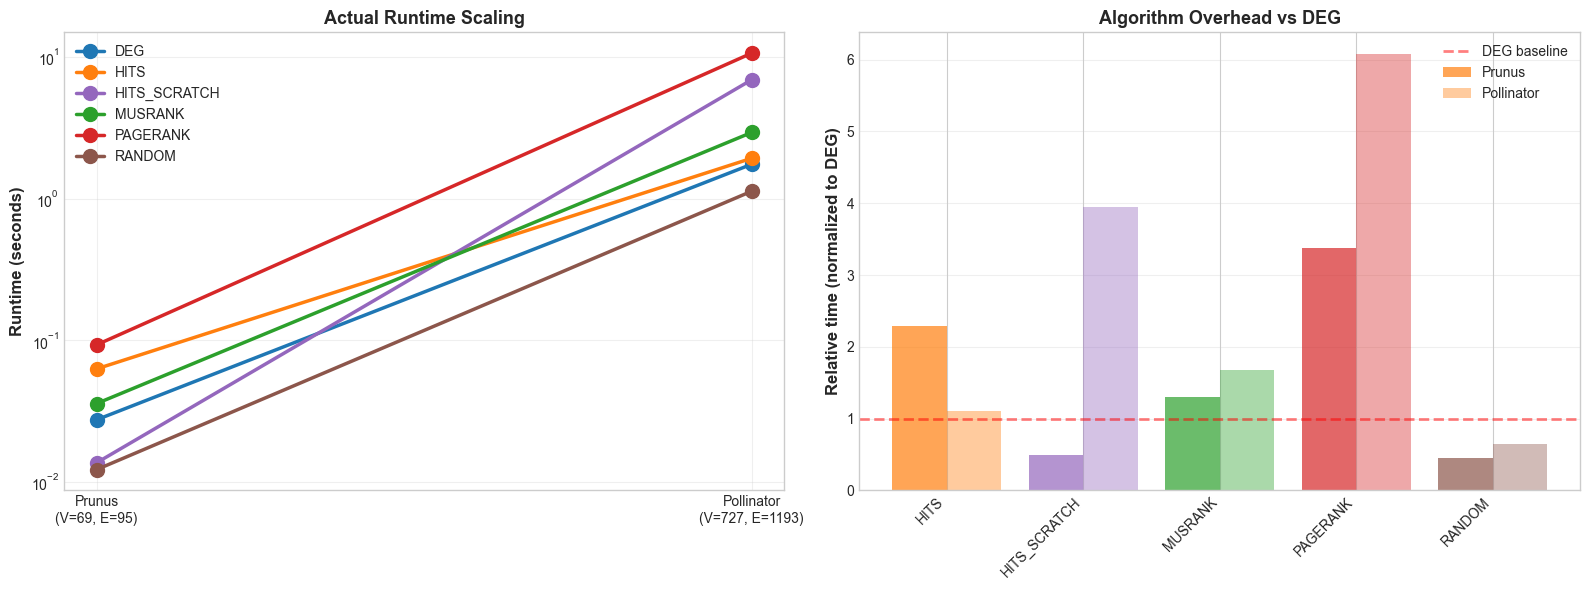


Key Insights:
• DEG & RANDOM: O(V²) - quadratic scaling, fast for small networks
• HITS, MUSRANK, PAGERANK: O(k·V·E) - depends on iterations × edges
• MUSRANK: Lower k (~100) but more complex per iteration
• For large networks: Iterative algorithms dominate runtime


In [19]:
# ===== Time Complexity Analysis (Integrated Version) =====
print("\n" + "="*80)
print("Algorithm Time Complexity Analysis")
print("="*80)

# ===== Theoretical Complexity Table =====

complexity_table = pd.DataFrame({
    'Algorithm': ['DEG', 'HITS', 'HITS_SCRATCH', 'MUSRANK', 'PAGERANK', 'RANDOM'],
    'Per-Step': ['O(V)', 'O(k·E)', 'O(k·E)', 'O(k·E)', 'O(k·E)', 'O(V)'],
    'Total': ['O(V²)', 'O(k·V·E)', 'O(k·V·E)', 'O(k·V·E)', 'O(k·V·E)', 'O(V²)'],
    'k (iterations)': ['—', '~500', '~1000', '~100', '~500', '—'],
    'Description': [
        'Degree counting',
        'HITS (library)',
        'HITS (custom)',
        'MusRank (bipartite)',
        'PageRank',
        'Random baseline'
    ]
})

print("\n" + complexity_table.to_string(index=False))

# ===== Actual Runtime vs Theoretical Scaling =====

# Use actual timing data from simulation
# timing_data should be available from previous cell

# Calculate theoretical scaling
V_prunus, E_prunus = 69, 95
V_poll, E_poll = 727, 1193

scaling = pd.DataFrame({
    'Metric': ['Nodes (V)', 'Edges (E)', 'V²', 'V·E'],
    'Ratio': [
        f'{V_poll/V_prunus:.1f}x',
        f'{E_poll/E_prunus:.1f}x',
        f'{(V_poll/V_prunus)**2:.1f}x',
        f'{(V_poll/V_prunus)*(E_poll/E_prunus):.1f}x'
    ],
    'Expected for': [
        '—',
        '—',
        'DEG, RANDOM',
        'HITS, MUSRANK, PAGERANK'
    ]
})

print("\n" + "="*80)
print("Theoretical Scaling (Pollinator / Prunus):")
print("="*80)
print(scaling.to_string(index=False))

# ===== Visualization =====

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual Runtime with Complexity Annotations
if 'timing_data' in globals() or 'timing_data' in locals():
    timing_df = pd.DataFrame(timing_data)
    
    algorithms = ['DEG', 'HITS', 'HITS_SCRATCH', 'MUSRANK', 'PAGERANK', 'RANDOM']
    colors = {
        'DEG': '#1f77b4', 'HITS': '#ff7f0e', 'HITS_SCRATCH': '#9467bd',
        'MUSRANK': '#2ca02c', 'PAGERANK': '#d62728', 'RANDOM': '#8c564b'
    }
    
    # Group by complexity class
    x_pos = {'Prunus': 0, 'Pollinator': 1}
    
    for alg in algorithms:
        times = []
        for net in ['Prunus', 'Pollinator']:
            t = timing_df[(timing_df['network']==net) & (timing_df['strategy']==alg)]['time'].values
            times.append(t[0] if len(t) > 0 else 0)
        
        ax1.plot([0, 1], times, marker='o', linewidth=2.5, markersize=10,
                label=alg, color=colors[alg])
    
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Prunus\n(V=69, E=95)', 'Pollinator\n(V=727, E=1193)'])
    ax1.set_ylabel('Runtime (seconds)', fontsize=12, fontweight='bold')
    ax1.set_title('Actual Runtime Scaling', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Plot 2: Speedup comparison (normalized to DEG)
    for net in ['Prunus', 'Pollinator']:
        deg_time = timing_df[(timing_df['network']==net) & (timing_df['strategy']=='DEG')]['time'].values[0]
        speedups = []
        labels = []
        cols = []
        
        for alg in algorithms:
            if alg != 'DEG':
                t = timing_df[(timing_df['network']==net) & (timing_df['strategy']==alg)]['time'].values[0]
                speedups.append(t / deg_time)
                labels.append(alg)
                cols.append(colors[alg])
        
        x = np.arange(len(labels))
        if net == 'Prunus':
            ax2.bar(x - 0.2, speedups, 0.4, label=net, alpha=0.7, color=cols)
        else:
            ax2.bar(x + 0.2, speedups, 0.4, label=net, alpha=0.4, color=cols)
    
    ax2.axhline(y=1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='DEG baseline')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_ylabel('Relative time (normalized to DEG)', fontsize=12, fontweight='bold')
    ax2.set_title('Algorithm Overhead vs DEG', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

else:
    ax1.text(0.5, 0.5, 'Run simulation with timing first', 
            ha='center', va='center', fontsize=14)
    ax2.text(0.5, 0.5, 'No timing data available', 
            ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Key Insights:")
print("="*80)
print("• DEG & RANDOM: O(V²) - quadratic scaling, fast for small networks")
print("• HITS, MUSRANK, PAGERANK: O(k·V·E) - depends on iterations × edges")
print("• MUSRANK: Lower k (~100) but more complex per iteration")
print("• For large networks: Iterative algorithms dominate runtime")
print("="*80)



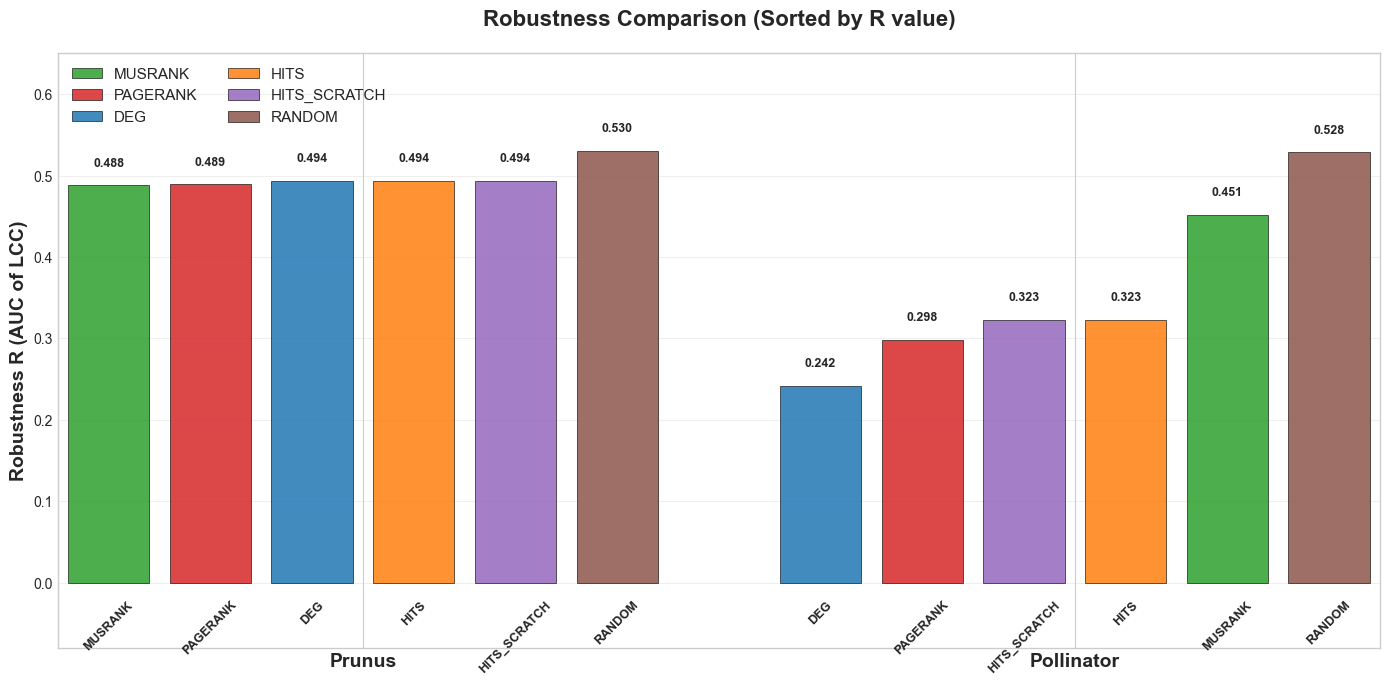

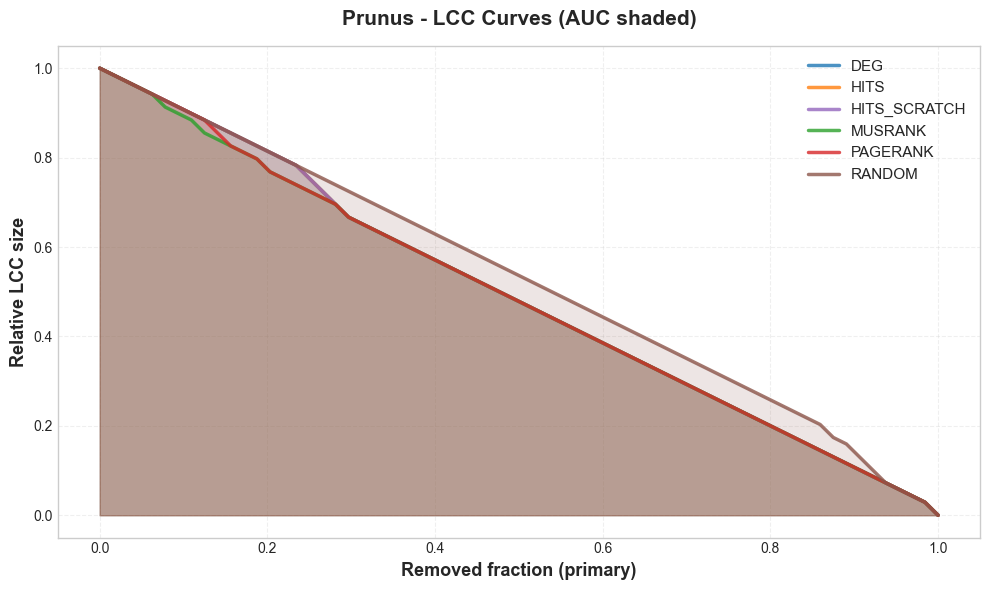

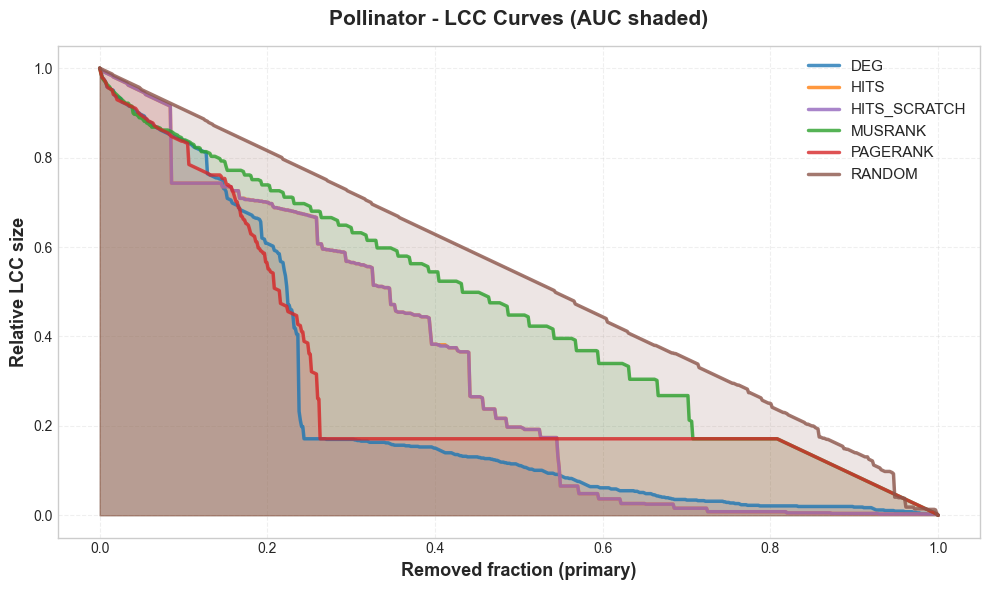

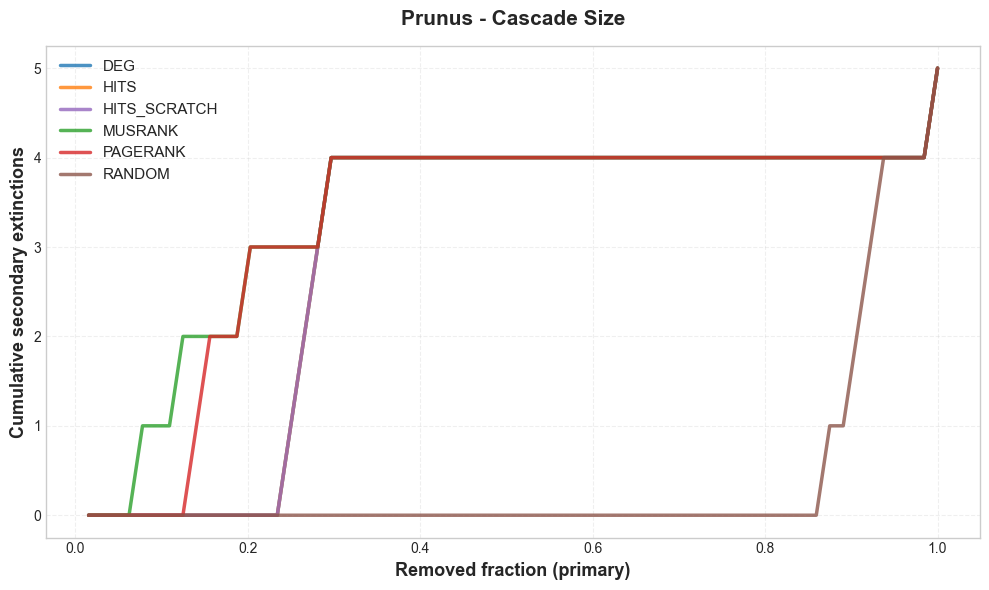

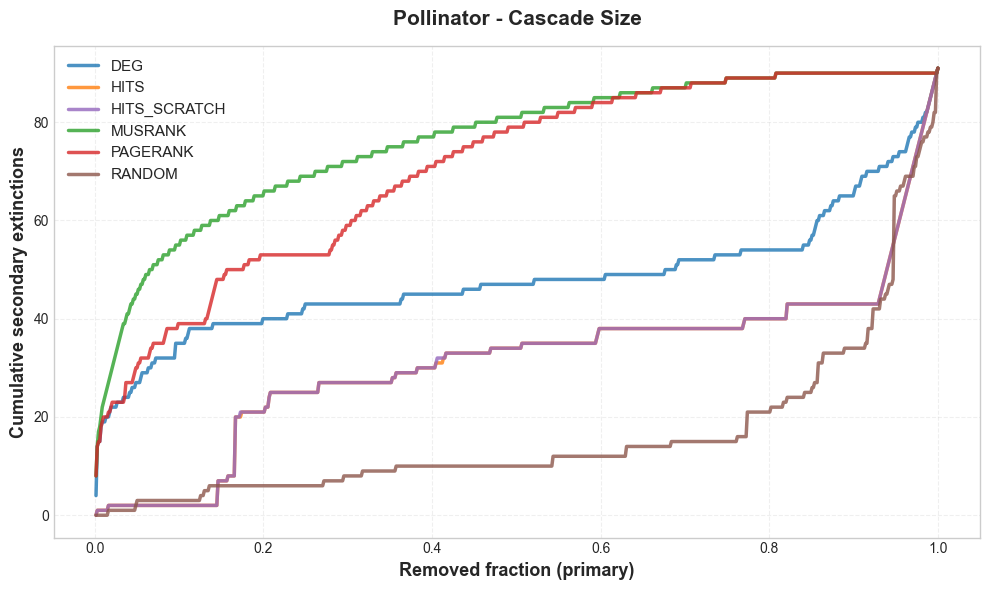

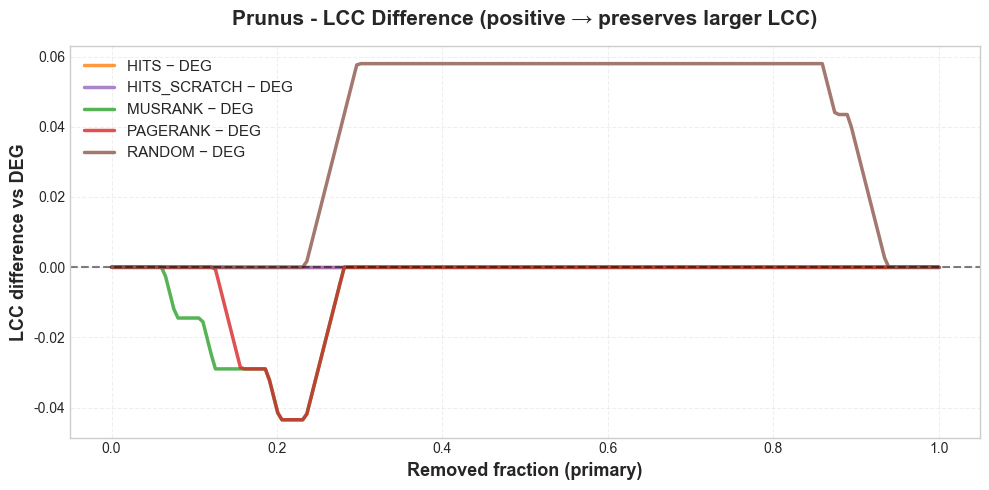

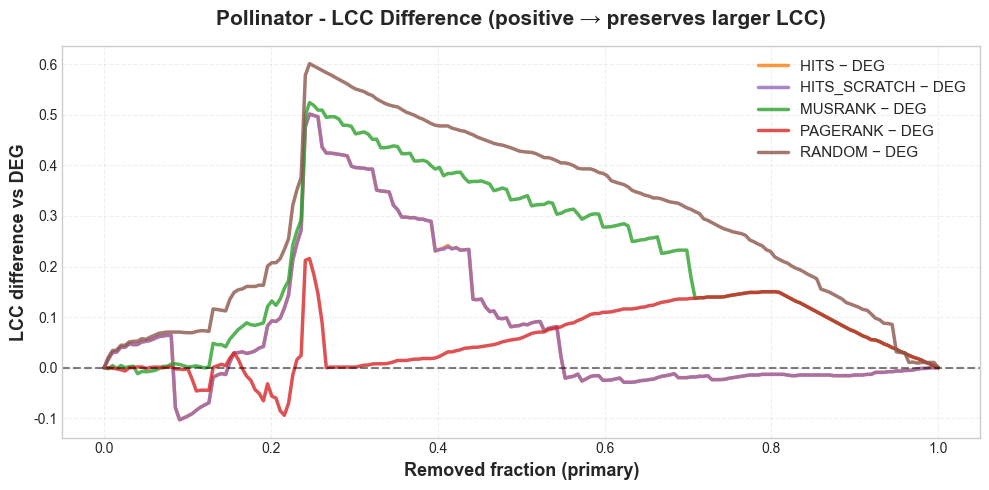

In [20]:
# ===== 4. Enhanced analysis plots (All 6 algorithms) =====
from pathlib import Path

# Style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        import seaborn as sns
        sns.set_theme(style='whitegrid')

# ------------------------------- Common setup -------------------------------
RESULTS_DIR = REPO_ROOT / 'tests' / 'results'
NETWORKS = ['Prunus', 'Pollinator']
STRATEGIES = ['DEG', 'HITS', 'HITS_SCRATCH', 'MUSRANK', 'PAGERANK', 'RANDOM']
COLORS = {
    'DEG': '#1f77b4',           # Blue
    'HITS': '#ff7f0e',          # Orange
    'HITS_SCRATCH': '#9467bd',  # Purple
    'MUSRANK': '#2ca02c',       # Green
    'PAGERANK': '#d62728',      # Red
    'RANDOM': '#8c564b'         # Brown
}

def ensure_auc_summary() -> pd.DataFrame:
    summary_path = RESULTS_DIR / 'robustness_summary.csv'
    if summary_path.exists():
        return pd.read_csv(summary_path)

    rows = []
    for net in NETWORKS:
        for strat in STRATEGIES:
            fp = RESULTS_DIR / f'{net}_{strat}_removal.csv'
            if not fp.exists():
                continue
            df = pd.read_csv(fp).sort_values('removed_fraction_primary')
            x = df['removed_fraction_primary'].to_numpy()
            y = df['lcc_ratio'].to_numpy()
            if len(x) == 0:
                continue
            if x[0] > 0:
                x = np.concatenate([[0.0], x]); y = np.concatenate([[1.0], y])
            if x[-1] < 1.0:
                x = np.concatenate([x, [1.0]]); y = np.concatenate([y, [0.0]])
            auc = float(np.trapz(y, x))
            rows.append({'network': net, 'strategy': strat, 'R': auc})

    summary = pd.DataFrame(rows)
    summary.to_csv(summary_path, index=False)
    return summary

def load_curve(net: str, strat: str):
    fp = RESULTS_DIR / f'{net}_{strat}_removal.csv'
    if not fp.exists():
        return np.array([0.0, 1.0]), np.array([1.0, 0.0])
    df = pd.read_csv(fp).sort_values('removed_fraction_primary')
    x = df['removed_fraction_primary'].to_numpy()
    y = df['lcc_ratio'].to_numpy()
    if len(x) == 0:
        return np.array([0.0, 1.0]), np.array([1.0, 0.0])
    if x[0] > 0:
        x = np.concatenate([[0.0], x]); y = np.concatenate([[1.0], y])
    if x[-1] < 1.0:
        x = np.concatenate([x, [1.0]]); y = np.concatenate([y, [0.0]])
    return x, y

summary = ensure_auc_summary()

# -------------------------- 4.1 Robustness bar chart ------------------------
pivot = summary.pivot(index='network', columns='strategy', values='R').reindex(index=NETWORKS, columns=STRATEGIES)

fig, ax = plt.subplots(figsize=(14, 7))

for net_idx, net in enumerate(NETWORKS):
    # 获取该网络的所有算法的R值，并排序
    net_data = []
    for strat in STRATEGIES:
        val = pivot.loc[net, strat]
        if not np.isnan(val):
            net_data.append((strat, val))
    
    # 按R值从小到大排序
    net_data.sort(key=lambda x: x[1])
    
    # 绘制排序后的柱子
    x_positions = np.arange(len(net_data))
    for i, (strat, val) in enumerate(net_data):
        x_pos = net_idx * (len(net_data) + 1) + i  # 每个网络之间留间隔
        bar = ax.bar(x_pos, val, width=0.8, color=COLORS[strat], 
                     edgecolor='black', linewidth=0.5, alpha=0.85, label=strat if net_idx == 0 else "")
        # 添加数值标签
        ax.text(x_pos, val + 0.02, f'{val:.3f}', 
               ha='center', va='bottom', fontsize=9, fontweight='bold')
        # 在柱子底部添加算法名称
        ax.text(x_pos, -0.02, strat, ha='center', va='top', 
               fontsize=9, rotation=45, fontweight='bold')

# 设置X轴刻度（网络名称）
network_positions = [len(STRATEGIES)/2 - 0.5, len(STRATEGIES) + len(STRATEGIES)/2 + 0.5]
ax.set_xticks(network_positions)
ax.set_xticklabels(NETWORKS, fontsize=14, fontweight='bold')

ax.set_ylabel('Robustness R (AUC of LCC)', fontsize=14, fontweight='bold')
ax.set_title('Robustness Comparison (Sorted by R value)', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(-0.08, 0.65)  # 留出空间给底部标签
ax.set_xlim(-0.5, len(STRATEGIES) * 2 + 0.5)

# 去重图例（只显示每个算法一次）
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=11, framealpha=0.95, ncol=2)

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# -------------------- 4.2 LCC curves with AUC shading ----------------
for net in NETWORKS:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strat in STRATEGIES:
        x, y = load_curve(net, strat)
        ax.plot(x, y, label=strat, color=COLORS[strat], linewidth=2.5, alpha=0.8)
        ax.fill_between(x, y, alpha=0.15, color=COLORS[strat])
    ax.set_xlabel('Removed fraction (primary)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Relative LCC size', fontsize=13, fontweight='bold')
    ax.set_title(f'{net} - LCC Curves (AUC shaded)', fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

# ------------------ 4.3 Cumulative secondary extinctions --------------------
for net in NETWORKS:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strat in STRATEGIES:
        fp = RESULTS_DIR / f'{net}_{strat}_removal.csv'
        if not fp.exists():
            continue
        df = pd.read_csv(fp).sort_values('removed_fraction_primary')
        cum = df['removed_secondary_count'].cumsum()
        ax.plot(df['removed_fraction_primary'], cum, label=strat, 
               color=COLORS[strat], linewidth=2.5, alpha=0.8)
    ax.set_xlabel('Removed fraction (primary)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Cumulative secondary extinctions', fontsize=13, fontweight='bold')
    ax.set_title(f'{net} - Cascade Size', fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

# ------------------ 4.4 LCC differences vs DEG baseline --------------------
for net in NETWORKS:
    x_deg, y_deg = load_curve(net, 'DEG')
    xs = np.linspace(0, 1, 200)
    y_deg_i = np.interp(xs, x_deg, y_deg)

    fig, ax = plt.subplots(figsize=(10, 5))
    for strat in ['HITS', 'HITS_SCRATCH', 'MUSRANK', 'PAGERANK', 'RANDOM']:
        x_s, y_s = load_curve(net, strat)
        y_s_i = np.interp(xs, x_s, y_s)
        delta = y_s_i - y_deg_i
        ax.plot(xs, delta, color=COLORS[strat], label=f'{strat} − DEG', 
               linewidth=2.5, alpha=0.8)

    ax.axhline(0, color='black', linewidth=1.5, linestyle='--', alpha=0.5)
    ax.set_xlabel('Removed fraction (primary)', fontsize=13, fontweight='bold')
    ax.set_ylabel('LCC difference vs DEG', fontsize=13, fontweight='bold')
    ax.set_title(f'{net} - LCC Difference (positive → preserves larger LCC)', 
                fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


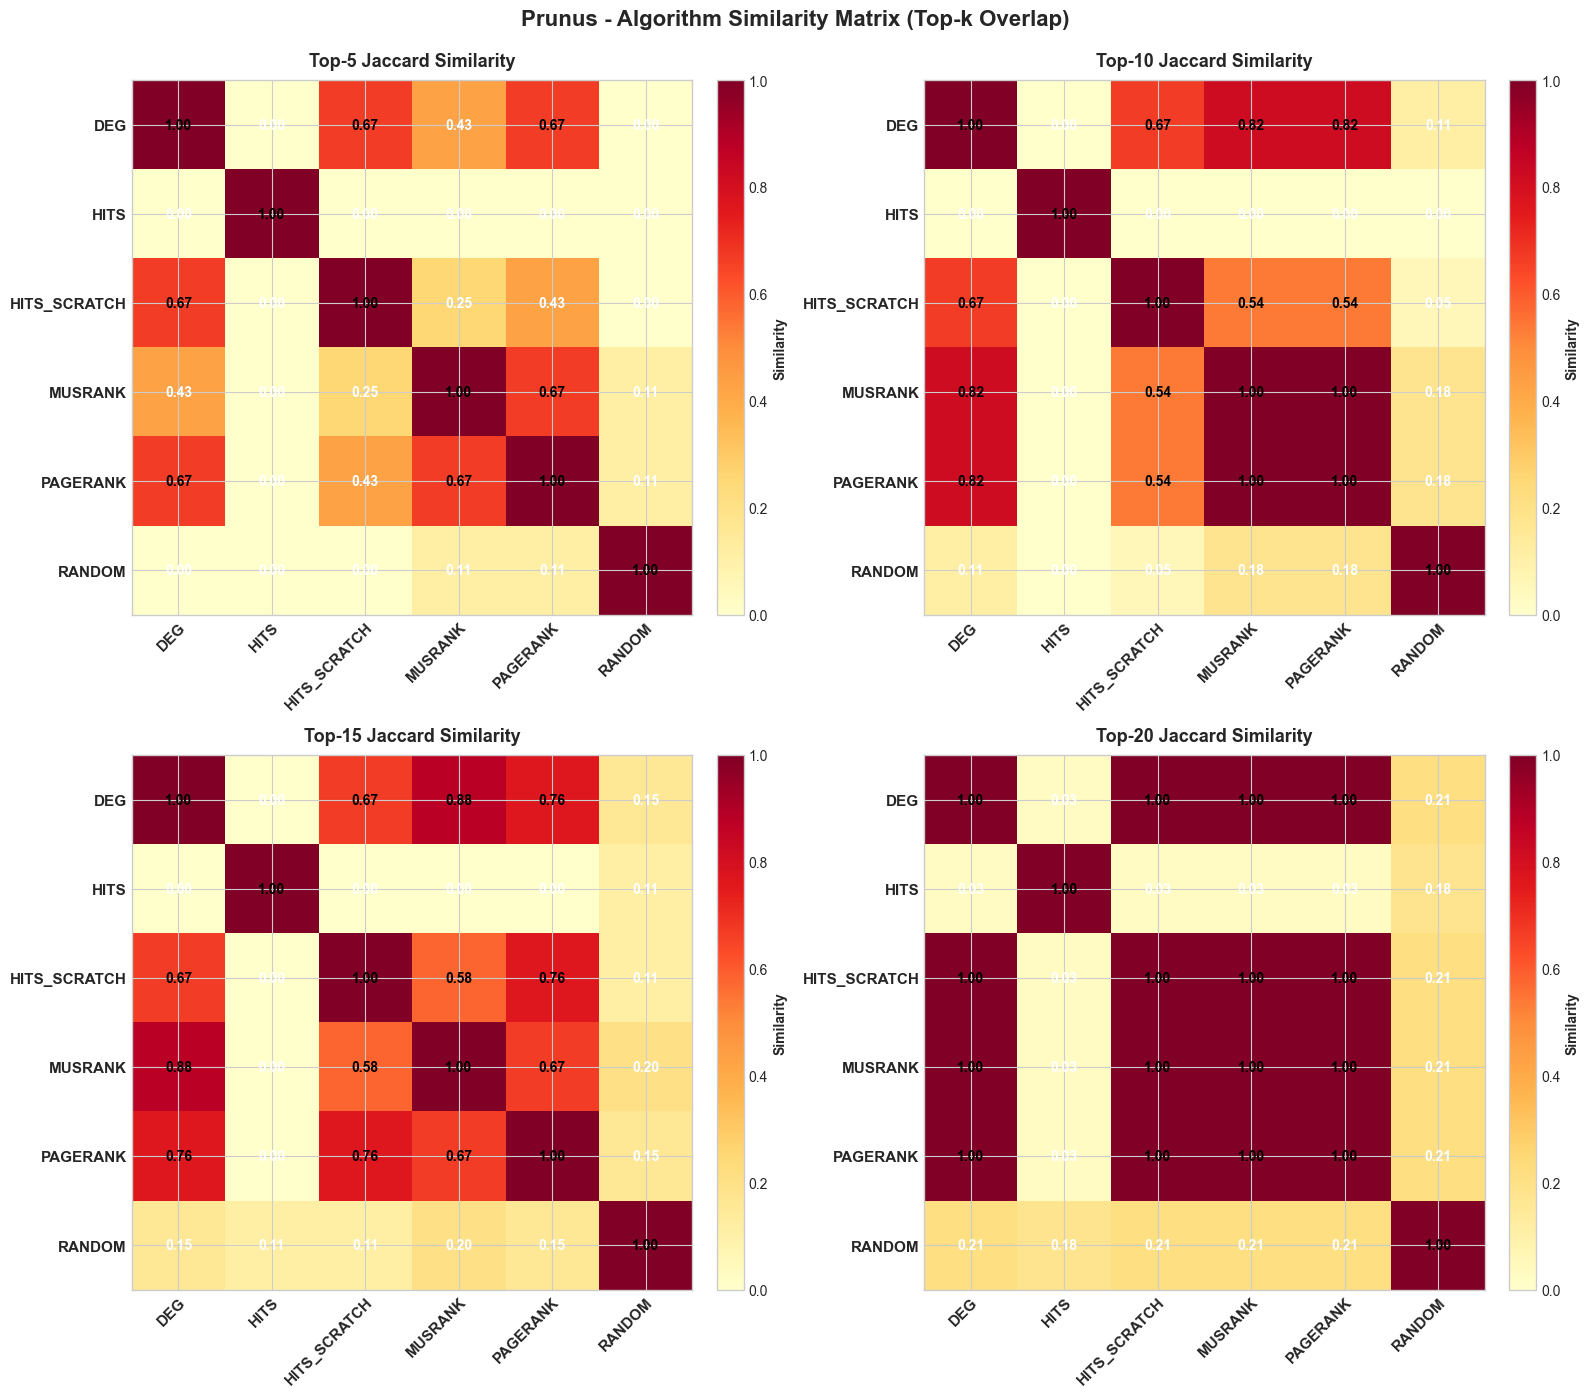

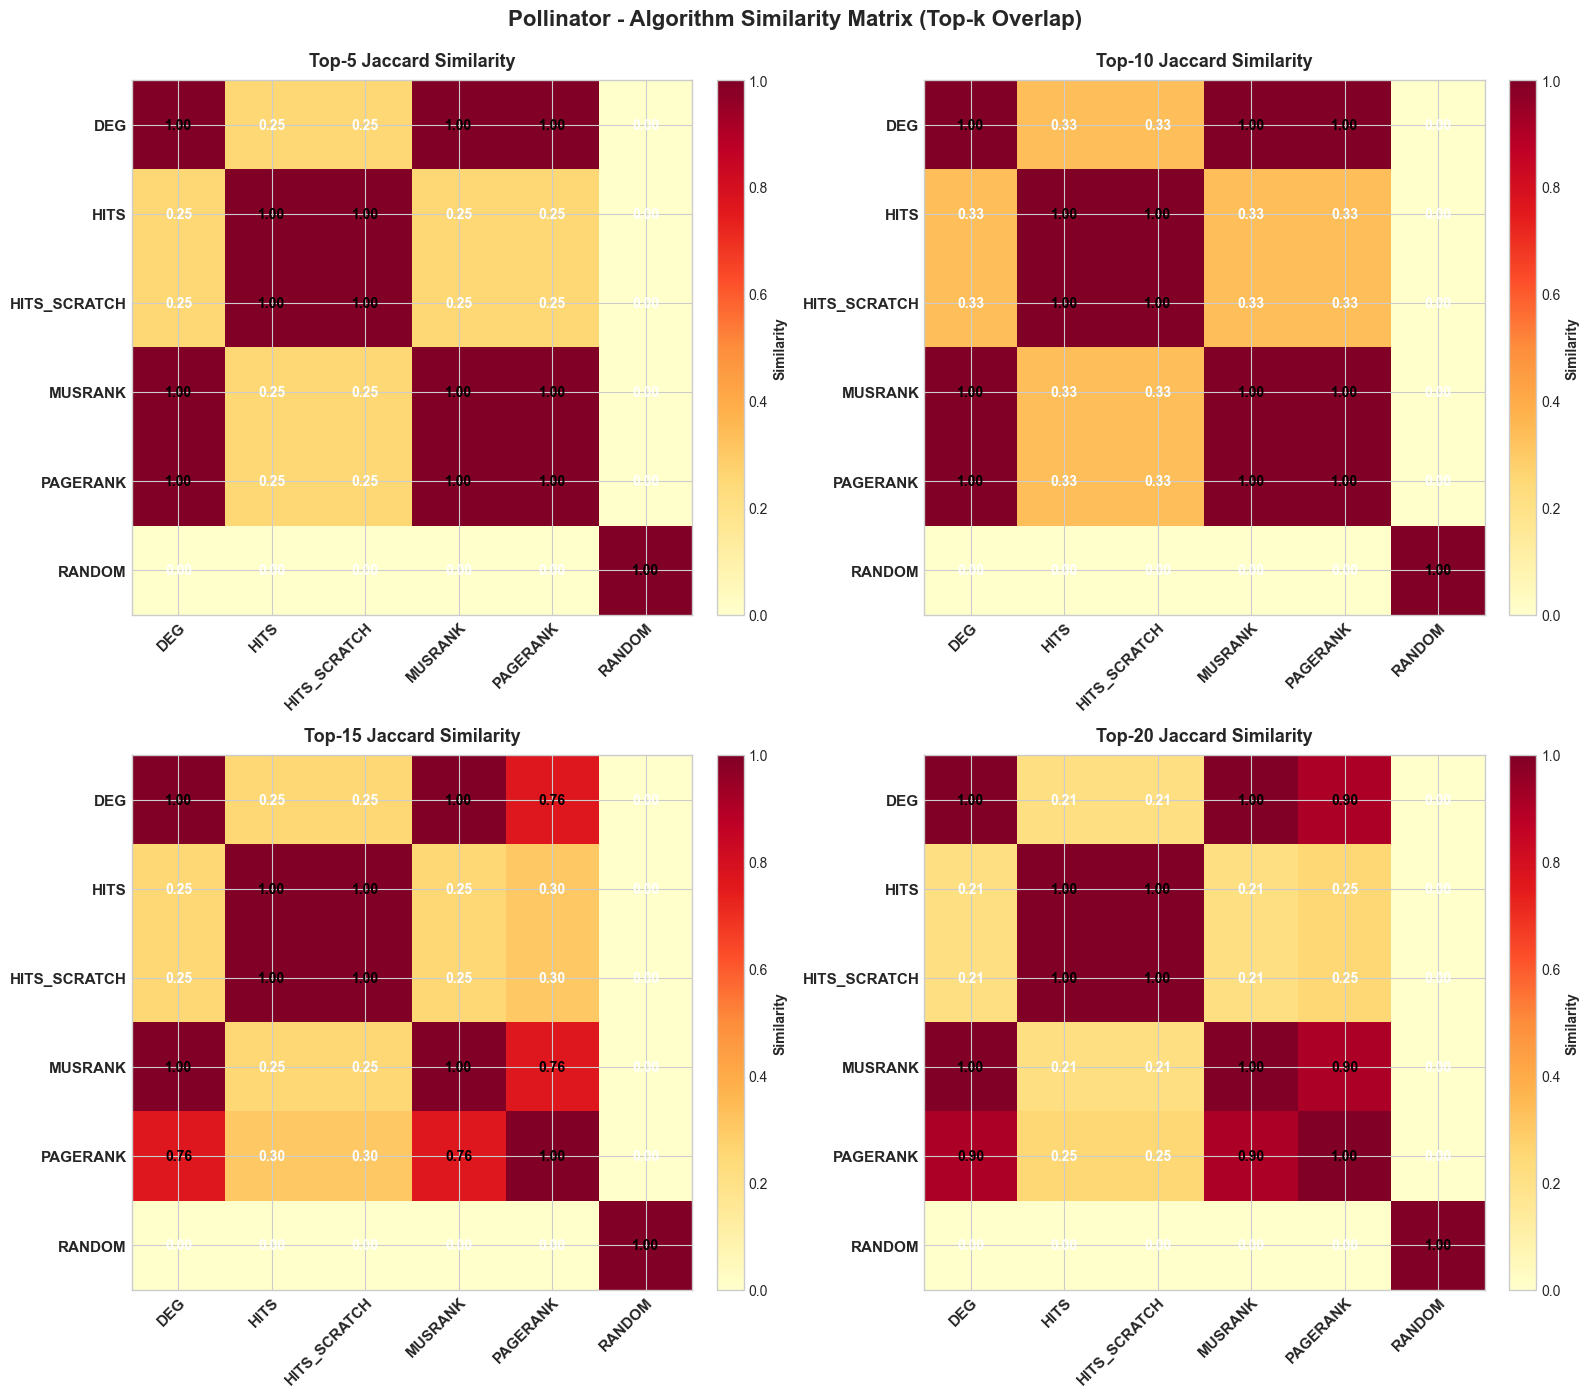


Top-k similarity analysis completed!


In [ ]:
# ===== 5. Top-k overlap: Pairwise similarity heatmap (all 6 algorithms) =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from degree_strategy import degree_strategy as degree_scores
from hits_strategy import hits_strategy as hits_scores
from hits_strategy import hits_strategy_scratch as hits_scores_scratch
from musrank_strategy import musrank as musrank_scores
from pageRank import pageRank as pageRanks_scores
from random_score import score_random as random_scores

def jaccard_similarity(list_a, list_b, k):
    """计算两个排序列表的 Top-k Jaccard 相似度"""
    A = set(list_a[:k])
    B = set(list_b[:k])
    if not A and not B:
        return 1.0
    union = A | B
    if not union:
        return 0.0
    return len(A & B) / len(union)

# 算法列表
ALGORITHMS = ['DEG', 'HITS', 'HITS_SCRATCH', 'MUSRANK', 'PAGERANK', 'RANDOM']

for net_name, G in [("Prunus", G_prunus), ("Pollinator", G_pollinator)]:
    # Ensure bipartite flag
    for n, d in G.nodes(data=True):
        if 'bipartite' not in d:
            if d.get('type')=='active': d['bipartite']=0
            elif d.get('type')=='passive': d['bipartite']=1

    # 计算所有算法的分数
    Gu = G.to_undirected()
    
    deg = degree_scores(Gu)
    hit = hits_scores(Gu)
    hsc = hits_scores_scratch(Gu)

    # --- 修复 MusRank 返回类型 ---
    mus_result = musrank_scores(Gu)
    if isinstance(mus_result, tuple) and len(mus_result) == 2:
        mus = mus_result[0]  # 只取 active 节点的分数
    else:
        mus = mus_result

    
    # PageRank
    try:
        adj = {u: list(Gu.neighbors(u)) for u in Gu.nodes()}
        pr_scores = pageRanks_scores(adj,500)

    except:
        pr_scores = {n: 0.0 for n in Gu.nodes()}
    
    # Random (固定种子)
    import random
    rng = random.Random(42)
    rand_scores = random_scores(G, rng)

    # 只考虑 active 节点
    active_nodes = [n for n, d in G.nodes(data=True) if d.get('type')=='active']
    
    # 排序
    rankings = {
        'DEG': sorted(active_nodes, key=lambda n: (-deg.get(n,0.0), str(n))),
        'HITS': sorted(active_nodes, key=lambda n: (-hit.get(n,0.0), str(n))),
        'HITS_SCRATCH': sorted(active_nodes, key=lambda n: (-hsc.get(n,0.0), str(n))),
        'MUSRANK': sorted(active_nodes, key=lambda n: (-mus.get(n,0.0), str(n))),
        'PAGERANK': sorted(active_nodes, key=lambda n: (-pr_scores.get(n,0.0), str(n))),
        'RANDOM': sorted(active_nodes, key=lambda n: (-rand_scores.get(n,0.0), str(n)))
    }

    # 创建 2x2 子图：k=5, 10, 15, 20
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    ks = [5, 10, 15, 20]
    
    for idx, k in enumerate(ks):
        ax = axes[idx // 2, idx % 2]
        
        # 计算相似度矩阵
        n_alg = len(ALGORITHMS)
        sim_matrix = np.zeros((n_alg, n_alg))
        
        for i, alg1 in enumerate(ALGORITHMS):
            for j, alg2 in enumerate(ALGORITHMS):
                if i == j:
                    sim_matrix[i, j] = 1.0
                else:
                    sim_matrix[i, j] = jaccard_similarity(rankings[alg1], rankings[alg2], k)
        
        # 绘制热力图
        im = ax.imshow(sim_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
        
        # 设置刻度
        ax.set_xticks(np.arange(n_alg))
        ax.set_yticks(np.arange(n_alg))
        ax.set_xticklabels(ALGORITHMS, fontsize=11, fontweight='bold')
        ax.set_yticklabels(ALGORITHMS, fontsize=11, fontweight='bold')
        
        # 旋转X轴标签
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # 添加数值标签
        for i in range(n_alg):
            for j in range(n_alg):
                text = ax.text(j, i, f'{sim_matrix[i, j]:.2f}',
                             ha="center", va="center", 
                             color="black" if sim_matrix[i, j] > 0.5 else "white",
                             fontsize=10, fontweight='bold')
        
        ax.set_title(f'Top-{k} Jaccard Similarity', fontsize=13, fontweight='bold', pad=10)
        
        # 添加颜色条
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Similarity', fontsize=10, fontweight='bold')
    
    fig.suptitle(f'{net_name} - Algorithm Similarity Matrix (Top-k Overlap)', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("Top-k similarity analysis completed!")
print("="*80)


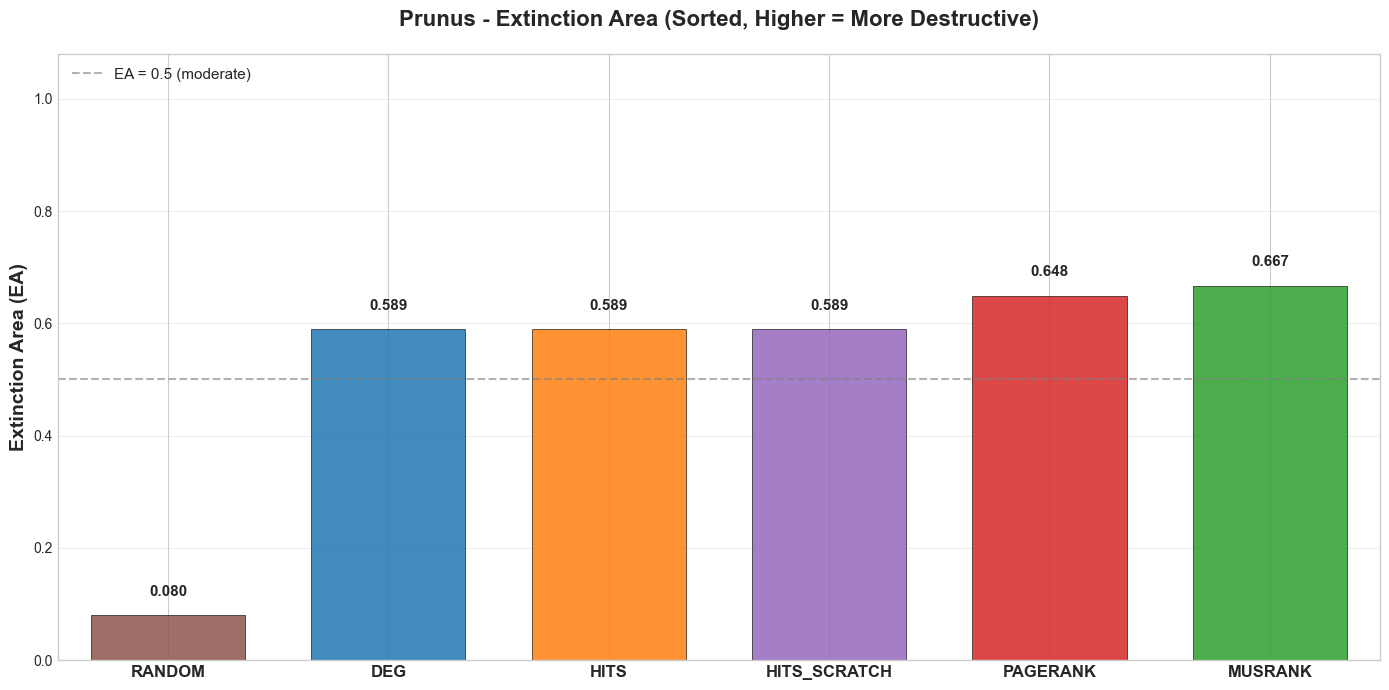

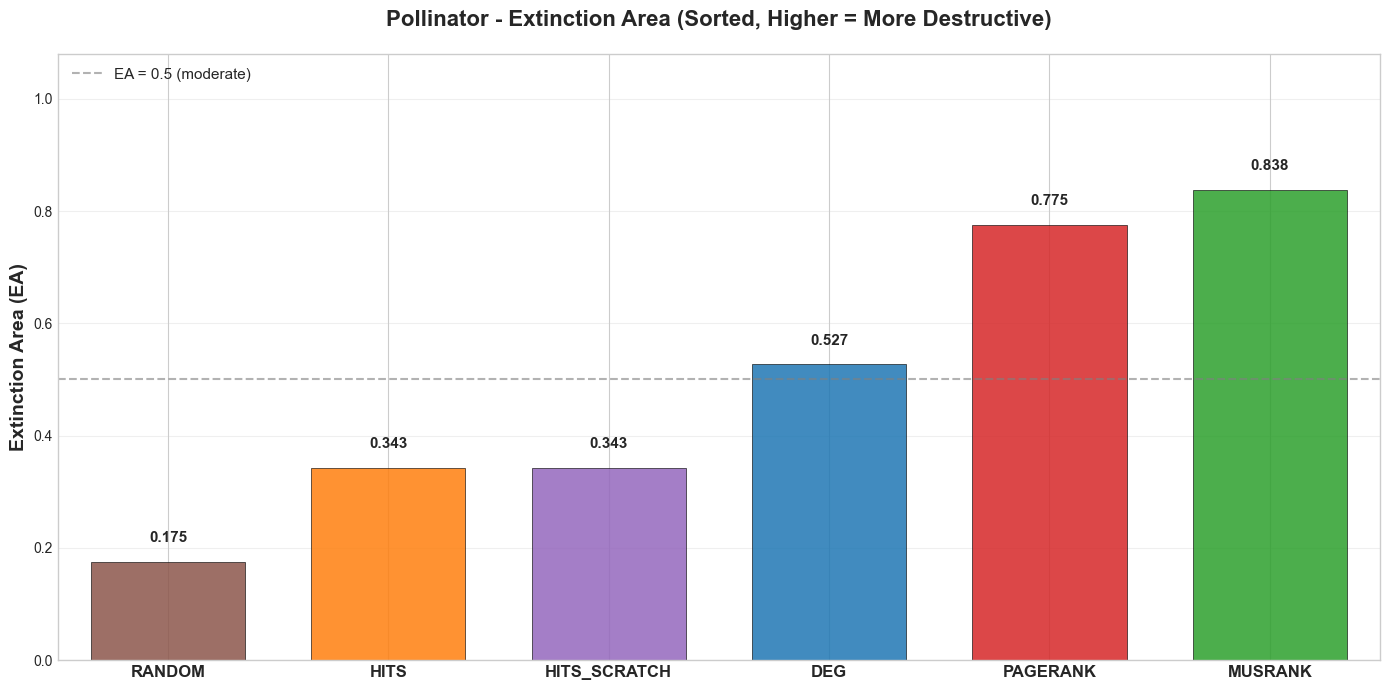


Extinction Area (EA) Summary:
   network     strategy       EA
    Prunus          DEG 0.589063
    Prunus         HITS 0.589063
    Prunus HITS_SCRATCH 0.589063
    Prunus      MUSRANK 0.667187
    Prunus     PAGERANK 0.648438
    Prunus       RANDOM 0.079688
Pollinator          DEG 0.526815
Pollinator         HITS 0.342778
Pollinator HITS_SCRATCH 0.342875
Pollinator      MUSRANK 0.838062
Pollinator     PAGERANK 0.774758
Pollinator       RANDOM 0.174810

✓ Saved to ea_summary.csv

Note: Higher EA = More destructive algorithm
      EA > 0.5: High destructiveness
      EA < 0.5: Low destructiveness


In [22]:
# ===== 2c. Extinction Area (EA) — paper definition (All 6 algorithms) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NETWORKS = ['Prunus', 'Pollinator']
STRATEGIES = ['DEG', 'HITS', 'HITS_SCRATCH', 'MUSRANK', 'PAGERANK', 'RANDOM']
COLORS = {
    'DEG': '#1f77b4',           # Blue
    'HITS': '#ff7f0e',          # Orange
    'HITS_SCRATCH': '#9467bd',  # Purple
    'MUSRANK': '#2ca02c',       # Green
    'PAGERANK': '#d62728',      # Red
    'RANDOM': '#8c564b'         # Brown
}

# passive totals from original graphs
PASSIVE_TOTAL = {
    'Prunus': sum(1 for _,d in G_prunus.nodes(data=True) if d.get('type')=='passive'),
    'Pollinator': sum(1 for _,d in G_pollinator.nodes(data=True) if d.get('type')=='passive')
}

RESULTS_DIR = REPO_ROOT / 'tests' / 'results'
EA_rows = []

for net in NETWORKS:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 收集数据并排序
    ea_data = []
    for s in STRATEGIES:
        fp = RESULTS_DIR / f'{net}_{s}_removal.csv'
        if not fp.exists():
            EA = np.nan
        else:
            df = pd.read_csv(fp).sort_values('removed_fraction_primary')
            # x: removed active fraction; y: fraction of extinct passive species
            x = df['removed_fraction_primary'].to_numpy()
            y = df['removed_secondary_count'].cumsum().to_numpy() / max(1, PASSIVE_TOTAL[net])
            
            # pad endpoints as in paper
            if len(x)==0 or x[0] > 0:
                x = np.concatenate([[0.0], x])
                y = np.concatenate([[0.0], y])
            if x[-1] < 1.0:
                x = np.concatenate([x, [1.0]])
                y = np.concatenate([y, [1.0]])
            
            y = np.clip(y, 0.0, 1.0)
            EA = float(np.trapz(y, x))
        
        EA_rows.append({'network': net, 'strategy': s, 'EA': EA})
        if not np.isnan(EA):
            ea_data.append((s, EA))
    
    # 按 EA 值从小到大排序
    ea_data.sort(key=lambda x: x[1])
    
    # 绘制排序后的柱子
    x_positions = np.arange(len(ea_data))
    for i, (strat, ea_val) in enumerate(ea_data):
        bar = ax.bar(i, ea_val, color=COLORS[strat], width=0.7,
                    edgecolor='black', linewidth=0.5, alpha=0.85)
        
        # 添加数值标签（在柱子顶部，避免重叠）
        ax.text(i, ea_val + 0.03, f'{ea_val:.3f}', 
               ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 设置X轴刻度和标签（在底部）
    ax.set_xticks(x_positions)
    ax.set_xticklabels([s for s, _ in ea_data], fontsize=12, fontweight='bold', rotation=0)
    
    ax.set_xlim(-0.5, len(ea_data) - 0.5)
    ax.set_ylim(0, 1.08)  # 留出空间给顶部标签
    ax.set_ylabel('Extinction Area (EA)', fontsize=14, fontweight='bold')
    ax.set_title(f'{net} - Extinction Area (Sorted, Higher = More Destructive)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='y')
    
    # 添加参考线
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, label='EA = 0.5 (moderate)')
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    
    plt.tight_layout()
    plt.show()

# save summary
ea_summary = pd.DataFrame(EA_rows)
ea_summary.to_csv(RESULTS_DIR / 'ea_summary.csv', index=False)

print("\n" + "="*80)
print("Extinction Area (EA) Summary:")
print("="*80)
print(ea_summary.to_string(index=False))
print("\n✓ Saved to ea_summary.csv")
print("\nNote: Higher EA = More destructive algorithm")
print("      EA > 0.5: High destructiveness")
print("      EA < 0.5: Low destructiveness")



Algorithm Implementation Comparison: HITS (NetworkX) vs HITS_SCRATCH (Custom)

Network: Prunus

[1] Removal Order Consistency:
   - Total removal steps: HITS=64, SCRATCH=64
   - Exact matches: 64/64
   - Consistency rate: 100.00%

[2] Top-k Node Overlap on Initial Graph (Jaccard Index):
   - Top- 5: 1.000 (intersection=5, union=5)
   - Top-10: 1.000 (intersection=10, union=10)
   - Top-15: 1.000 (intersection=15, union=15)
   - Top-20: 1.000 (intersection=20, union=20)

[3] Initial Score Correlation:
   - Pearson correlation:  1.0000
   - Spearman correlation: 1.0000


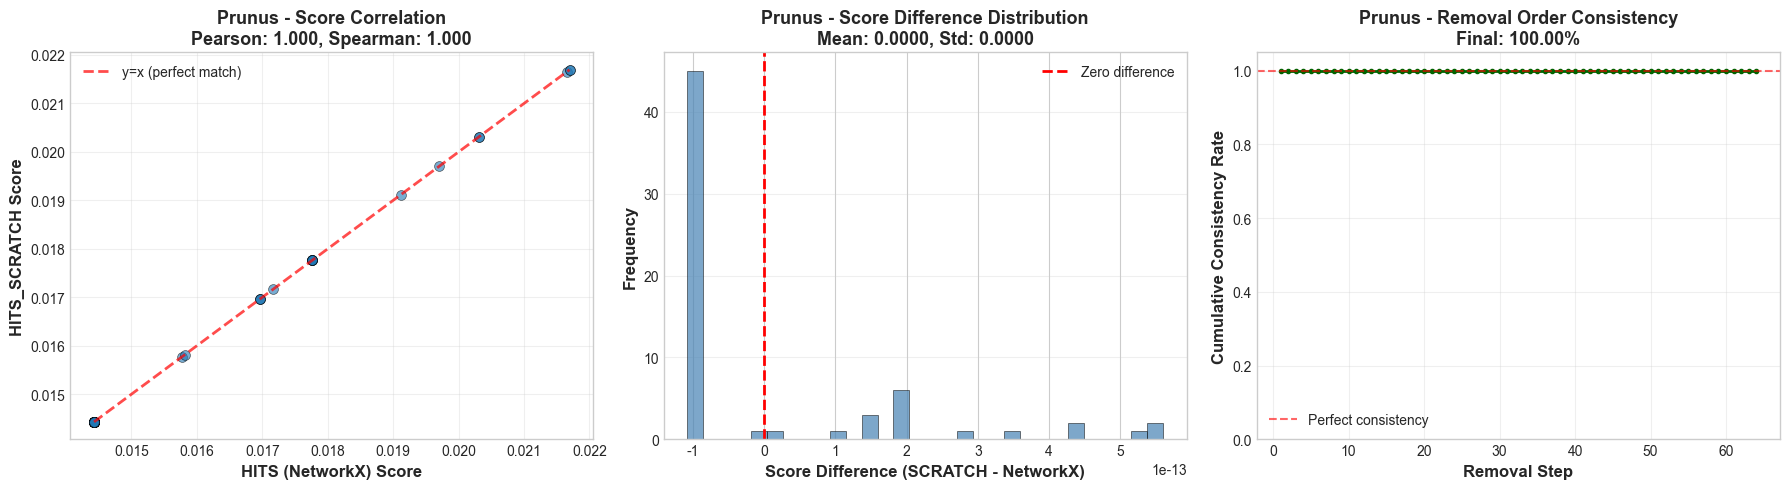


Network: Pollinator

[1] Removal Order Consistency:
   - Total removal steps: HITS=677, SCRATCH=677
   - Exact matches: 293/677
   - Consistency rate: 43.28%

[2] Top-k Node Overlap on Initial Graph (Jaccard Index):
   - Top- 5: 1.000 (intersection=5, union=5)
   - Top-10: 1.000 (intersection=10, union=10)
   - Top-15: 1.000 (intersection=15, union=15)
   - Top-20: 1.000 (intersection=20, union=20)

[3] Initial Score Correlation:
   - Pearson correlation:  1.0000
   - Spearman correlation: 1.0000


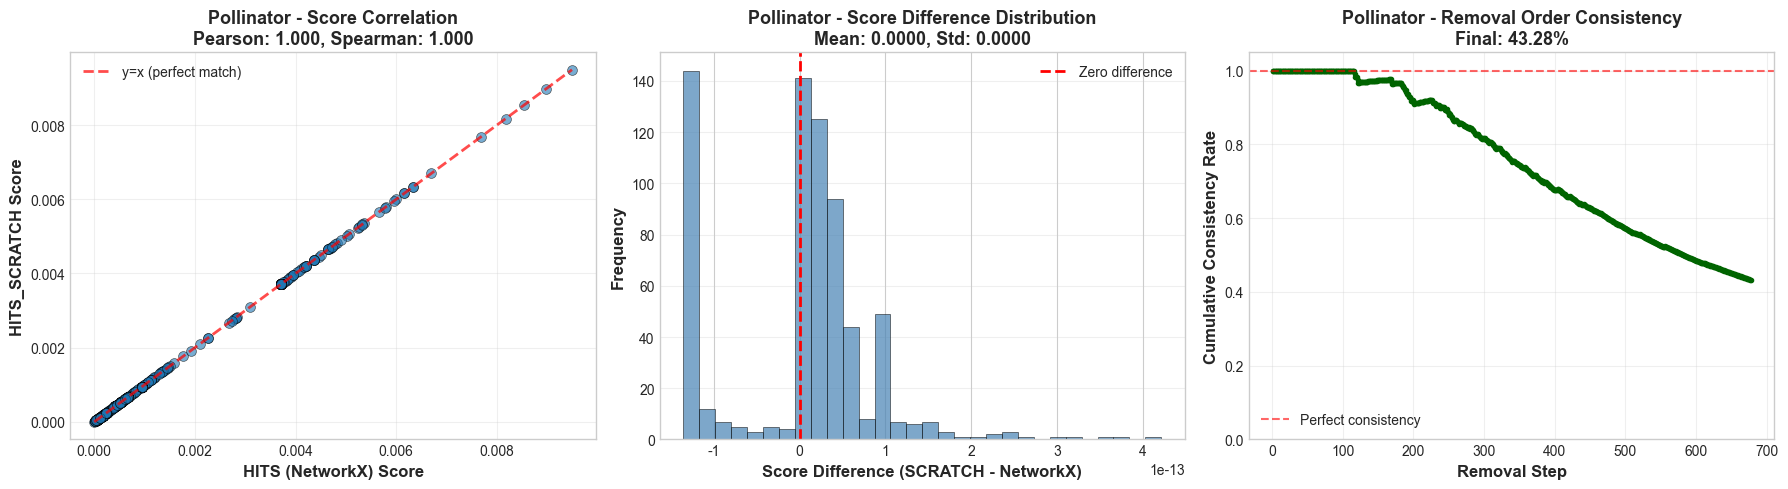


OK: Algorithm Implementation Comparison Complete

Interpretation Guide:
- Score scatter plot: Points closer to diagonal = more similar implementations
- Score difference distribution: Centered near 0 = small differences
- Removal order consistency: Shows % of steps where both implementations chose the same node
- Pearson correlation: Measures linear correlation (-1 to 1, closer to 1 = more correlated)
- Spearman correlation: Measures rank correlation (more robust to outliers)


In [23]:
# ===== 11. Algorithm Implementation Comparison (HITS vs HITS_SCRATCH) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

print("\n" + "="*80)
print("Algorithm Implementation Comparison: HITS (NetworkX) vs HITS_SCRATCH (Custom)")
print("="*80)

NETWORKS = ['Prunus', 'Pollinator']
RESULTS_DIR = REPO_ROOT / 'tests' / 'results'

# Analyze each network
for net_name in NETWORKS:
    print(f"\n{'='*80}")
    print(f"Network: {net_name}")
    print(f"{'='*80}")
    
    # Load original network
    if net_name == 'Prunus':
        G_orig = G_prunus.copy()
    else:
        G_orig = G_pollinator.copy()
    
    # Load removal records from both implementations
    df_hits = pd.read_csv(RESULTS_DIR / f'{net_name}_HITS_removal.csv')
    df_scratch = pd.read_csv(RESULTS_DIR / f'{net_name}_HITS_SCRATCH_removal.csv')
    
    # Extract removal order
    removed_hits = df_hits['removed_node'].tolist()
    removed_scratch = df_scratch['removed_node'].tolist()
    
    # 1. Removal order consistency analysis
    min_len = min(len(removed_hits), len(removed_scratch))
    matches = sum(1 for i in range(min_len) if removed_hits[i] == removed_scratch[i])
    consistency_rate = matches / min_len if min_len > 0 else 0
    
    print(f"\n[1] Removal Order Consistency:")
    print(f"   - Total removal steps: HITS={len(removed_hits)}, SCRATCH={len(removed_scratch)}")
    print(f"   - Exact matches: {matches}/{min_len}")
    print(f"   - Consistency rate: {consistency_rate:.2%}")
    
    # 2. Top-k overlap analysis (on initial graph)
    # Use directed graph (consistent with simulation)
    active_nodes = [n for n, d in G_orig.nodes(data=True) if d.get('type') == 'active']
    
    try:
        # Calculate initial scores using score_active_nodes (with L1 normalization)
        scores_nx = score_active_nodes(G_orig, 'HITS')
        scores_scratch = score_active_nodes(G_orig, 'HITS_SCRATCH')
        
        # Sort by scores
        sorted_nx = sorted(scores_nx.items(), key=lambda x: x[1], reverse=True)
        sorted_scratch = sorted(scores_scratch.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\n[2] Top-k Node Overlap on Initial Graph (Jaccard Index):")
        for k in [5, 10, 15, 20]:
            if k > len(active_nodes):
                continue
            top_nx = set([node for node, _ in sorted_nx[:k]])
            top_scratch = set([node for node, _ in sorted_scratch[:k]])
            jaccard = len(top_nx & top_scratch) / len(top_nx | top_scratch) if len(top_nx | top_scratch) > 0 else 0
            print(f"   - Top-{k:2d}: {jaccard:.3f} (intersection={len(top_nx & top_scratch)}, union={len(top_nx | top_scratch)})")
        
        # 3. Score correlation analysis
        common_nodes = set(scores_nx.keys()) & set(scores_scratch.keys())
        if len(common_nodes) > 1:
            scores_nx_arr = np.array([scores_nx[n] for n in common_nodes])
            scores_scratch_arr = np.array([scores_scratch[n] for n in common_nodes])
            
            pearson_corr, _ = pearsonr(scores_nx_arr, scores_scratch_arr)
            spearman_corr, _ = spearmanr(scores_nx_arr, scores_scratch_arr)
            
            print(f"\n[3] Initial Score Correlation:")
            print(f"   - Pearson correlation:  {pearson_corr:.4f}")
            print(f"   - Spearman correlation: {spearman_corr:.4f}")
        
        # 4. Visualization: Score comparison plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 4.1 Score scatter plot
        ax = axes[0]
        scores_nx_arr = np.array([scores_nx.get(n, 0) for n in active_nodes])
        scores_scratch_arr = np.array([scores_scratch.get(n, 0) for n in active_nodes])
        
        ax.scatter(scores_nx_arr, scores_scratch_arr, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # Add diagonal line (perfect match)
        min_val = min(scores_nx_arr.min(), scores_scratch_arr.min())
        max_val = max(scores_nx_arr.max(), scores_scratch_arr.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.7, label='y=x (perfect match)')
        
        ax.set_xlabel('HITS (NetworkX) Score', fontsize=12, fontweight='bold')
        ax.set_ylabel('HITS_SCRATCH Score', fontsize=12, fontweight='bold')
        ax.set_title(f'{net_name} - Score Correlation\nPearson: {pearson_corr:.3f}, Spearman: {spearman_corr:.3f}', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # 4.2 Score difference histogram
        ax = axes[1]
        score_diff = scores_scratch_arr - scores_nx_arr
        ax.hist(score_diff, bins=30, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero difference')
        ax.set_xlabel('Score Difference (SCRATCH - NetworkX)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title(f'{net_name} - Score Difference Distribution\nMean: {score_diff.mean():.4f}, Std: {score_diff.std():.4f}', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        
        # 4.3 Removal order consistency (step-by-step)
        ax = axes[2]
        step_consistency = []
        for i in range(min_len):
            matches_so_far = sum(1 for j in range(i+1) if removed_hits[j] == removed_scratch[j])
            step_consistency.append(matches_so_far / (i+1))
        
        ax.plot(range(1, min_len+1), step_consistency, linewidth=2, color='darkgreen', marker='o', markersize=3)
        ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='Perfect consistency')
        ax.set_xlabel('Removal Step', fontsize=12, fontweight='bold')
        ax.set_ylabel('Cumulative Consistency Rate', fontsize=12, fontweight='bold')
        ax.set_title(f'{net_name} - Removal Order Consistency\nFinal: {consistency_rate:.2%}', 
                    fontsize=13, fontweight='bold')
        ax.set_ylim([0, 1.05])
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"WARNING:  Analysis failed: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*80)
print("OK: Algorithm Implementation Comparison Complete")
print("="*80)
print("\nInterpretation Guide:")
print("- Score scatter plot: Points closer to diagonal = more similar implementations")
print("- Score difference distribution: Centered near 0 = small differences")
print("- Removal order consistency: Shows % of steps where both implementations chose the same node")
print("- Pearson correlation: Measures linear correlation (-1 to 1, closer to 1 = more correlated)")
print("- Spearman correlation: Measures rank correlation (more robust to outliers)")



CONTROL TEST: Running HITS (NetworkX) Twice
This tests if the SAME algorithm produces consistent results.


Network: Prunus
Running HITS - Run 1...
Running HITS - Run 2...

Results:
  - Exact matches: 62/64
  - Consistency: 96.88%

Initial Score Check:
  - Mean difference: -0.000000000000000
  - Max abs diff: 0.000000000000000


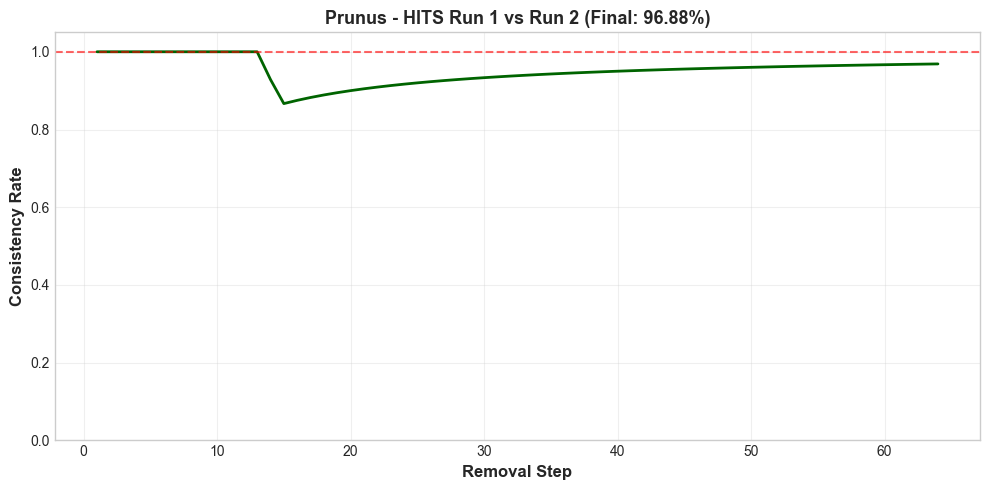


Network: Pollinator
Running HITS - Run 1...
Running HITS - Run 2...

Results:
  - Exact matches: 310/677
  - Consistency: 45.79%

Initial Score Check:
  - Mean difference: -0.000000000000000
  - Max abs diff: 0.000000000000000


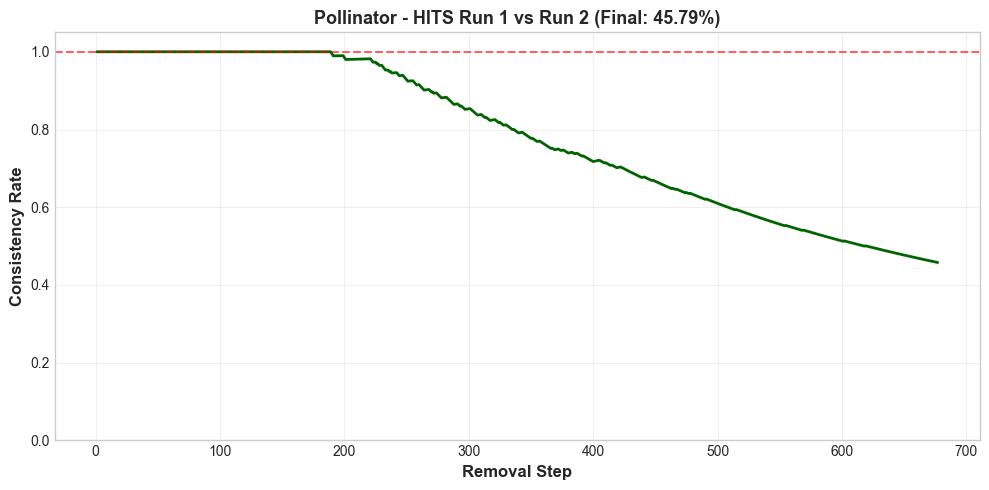


INTERPRETATION:
  - If consistency = 100%: Algorithm is fully deterministic
  - If consistency < 100%: There is randomness or numerical instability
  - This helps us understand if 44% between HITS and HITS_SCRATCH is normal


In [24]:
# ===== 11f. Control Test: Same Algorithm Twice =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

print("\n" + "="*80)
print("CONTROL TEST: Running HITS (NetworkX) Twice")
print("="*80)
print("This tests if the SAME algorithm produces consistent results.\n")

NETWORKS = ['Prunus', 'Pollinator']

for net_name in NETWORKS:
    print(f"\n{'='*80}")
    print(f"Network: {net_name}")
    print(f"{'='*80}")
    
    if net_name == 'Prunus':
        G_orig = G_prunus.copy()
    else:
        G_orig = G_pollinator.copy()
    
    # Run HITS twice with the SAME code
    print("Running HITS - Run 1...")
    df_hits1 = simulate_adaptive(G_orig.copy(), 'active', net_name, 'HITS')
    removed_1 = df_hits1['removed_node'].tolist()
    
    print("Running HITS - Run 2...")
    df_hits2 = simulate_adaptive(G_orig.copy(), 'active', net_name, 'HITS')
    removed_2 = df_hits2['removed_node'].tolist()
    
    # Compare
    min_len = min(len(removed_1), len(removed_2))
    matches = sum(1 for i in range(min_len) if removed_1[i] == removed_2[i])
    consistency = matches / min_len if min_len > 0 else 0
    
    print(f"\nResults:")
    print(f"  - Exact matches: {matches}/{min_len}")
    print(f"  - Consistency: {consistency:.2%}")
    
    # Also compare initial scores
    scores1 = score_active_nodes(G_orig, 'HITS')
    scores2 = score_active_nodes(G_orig, 'HITS')
    
    active_nodes = [n for n, d in G_orig.nodes(data=True) if d.get('type') == 'active']
    s1 = np.array([scores1.get(n, 0) for n in active_nodes])
    s2 = np.array([scores2.get(n, 0) for n in active_nodes])
    
    score_diff = s2 - s1
    print(f"\nInitial Score Check:")
    print(f"  - Mean difference: {score_diff.mean():.15f}")
    print(f"  - Max abs diff: {np.abs(score_diff).max():.15f}")
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    step_consistency = []
    for i in range(min_len):
        m = sum(1 for j in range(i+1) if removed_1[j] == removed_2[j])
        step_consistency.append(m / (i+1))
    
    ax.plot(range(1, min_len+1), step_consistency, linewidth=2, color='darkgreen')
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.6)
    ax.set_xlabel('Removal Step', fontsize=12, fontweight='bold')
    ax.set_ylabel('Consistency Rate', fontsize=12, fontweight='bold')
    ax.set_title(f'{net_name} - HITS Run 1 vs Run 2 (Final: {consistency:.2%})', fontsize=13, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("INTERPRETATION:")
print("  - If consistency = 100%: Algorithm is fully deterministic")
print("  - If consistency < 100%: There is randomness or numerical instability")
print("  - This helps us understand if 44% between HITS and HITS_SCRATCH is normal")
print("="*80)
